In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<h2>Loading dataset</h2>
<p>
Enter your own path to the nypd dataset
</p>

In [153]:
NYPD_DATASET_PATH = "NYPD_Complaint_Data_Historic.csv"

In [87]:
# Read data without columns with codes or IDs

columns_used = ['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'RPT_DT', 'OFNS_DESC', 'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'PARKS_NM', 'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX']

categorical_columns = ['OFNS_DESC', 'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'PARKS_NM', 'HADEVELOPT', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'PATROL_BORO', 'STATION_NAME', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX']

data = pd.read_csv(NYPD_DATASET_PATH, usecols=columns_used, parse_dates=['RPT_DT'])

In [88]:
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914838 entries, 0 to 8914837
Data columns (total 29 columns):
 #   Column             Dtype         
---  ------             -----         
 0   CMPLNT_FR_DT       object        
 1   CMPLNT_FR_TM       object        
 2   CMPLNT_TO_DT       object        
 3   CMPLNT_TO_TM       object        
 4   RPT_DT             datetime64[ns]
 5   OFNS_DESC          object        
 6   PD_DESC            object        
 7   CRM_ATPT_CPTD_CD   object        
 8   LAW_CAT_CD         object        
 9   BORO_NM            object        
 10  LOC_OF_OCCUR_DESC  object        
 11  PREM_TYP_DESC      object        
 12  JURIS_DESC         object        
 13  PARKS_NM           object        
 14  HADEVELOPT         object        
 15  X_COORD_CD         float64       
 16  Y_COORD_CD         float64       
 17  SUSP_AGE_GROUP     object        
 18  SUSP_RACE          object        
 19  SUSP_SEX           object        
 20  TRANSIT_DISTRICT   float

<h2>Data cleaning</h2>

In [89]:
# Dropping Lat Lon coordinates. Using X_COORD_CD and Y_COORD_CD for geolocation
data = data.drop(columns=['Latitude', 'Longitude', 'Lat_Lon'])

# Cleaning nulls and unknowns
data = data.replace(dict.fromkeys(['(null)', 'UNKNOWN'], np.NaN))

# Cleaning sex
sex_cols = ['SUSP_SEX', 'VIC_SEX']
for col in sex_cols:
    data[col] = data[col].where(data[col].isin(['M', 'F']), np.NaN)

# Cleaning age
age_groups = ['<18', '18-24', '25-44', '45-64', '65+']
age_cols = ['SUSP_AGE_GROUP', 'VIC_AGE_GROUP']
for col in age_cols:
    data[col] = data[col].where(data[col].isin(age_groups), np.NaN)

# Cleaning race
race_cols = ['SUSP_RACE', 'VIC_RACE']
for col in race_cols:
    data.loc[data[col] == 'OTHER', col] = np.NaN
    data.loc[data[col] == 'AMERICAN INDIAN/ALASKAN NATIVE', col] = 'AMERICAN INDIAN / ALASKAN NATIVE'

# Joining date and time columns into datetime column
data['CRIME_START'] = pd.to_datetime(data['CMPLNT_FR_DT'] + data['CMPLNT_FR_TM'], format='%m/%d/%Y%H:%M:%S', errors='coerce')
data['CRIME_END'] = pd.to_datetime(data['CMPLNT_TO_DT'] + data['CMPLNT_TO_TM'], format='%m/%d/%Y%H:%M:%S', errors='coerce')
data = data.drop(columns=['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM'])

# Calculating how long crime took (in minutes) if both CRIME_START and CRIME_END are not nan
data['CRIME_DURATION'] = ((data['CRIME_END'] - data['CRIME_START']).dt.total_seconds() // 60).astype('Int64')

# Grouping all crimes into 4 time periods
time_of_day_labels = ['Night (00:00-05:59)', 'Morning (06:00-11:59)', 'Afternoon (12:00-17:59)', 'Evening (18:00-23:59)']
bins = [0, 6, 12, 18, 24]
data['TIME_OF_DAY'] = pd.cut(data['CRIME_START'].dt.hour, bins=bins, labels=time_of_day_labels, right=False)
categorical_columns.append('TIME_OF_DAY')

# Assigning day of the week
data['DAY_OF_WEEK'] = data['CRIME_START'].dt.day_name()
categorical_columns.append('DAY_OF_WEEK')

# Adding column indicating whether crime was a violent crime 
# According to FBI - "violent crime is composed of four offenses: murder and nonnegligent manslaughter, forcible rape, robbery, and aggravated assault" (https://ucr.fbi.gov/crime-in-the-u.s/2011/crime-in-the-u.s.-2011/violent-crime)
violent_crimes = ['ASSAULT 3 & RELATED OFFENSES', 'FELONY ASSAULT', 'ROBBERY', 'RAPE', 'MURDER & NON-NEGL. MANSLAUGHTER']
data['IS_VIOLENT'] = np.where(data['OFNS_DESC'].isin(violent_crimes), 'VIOLENT CRIME', 'NON VIOLENT CRIME')
categorical_columns.append('IS_VIOLENT')

# Changing dtype to category
for col in categorical_columns:
    data[col] = data[col].astype('category')

<h2>Data analysis</h2>

In [93]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914838 entries, 0 to 8914837
Data columns (total 28 columns):
 #   Column             Dtype         
---  ------             -----         
 0   RPT_DT             datetime64[ns]
 1   OFNS_DESC          category      
 2   PD_DESC            category      
 3   CRM_ATPT_CPTD_CD   category      
 4   LAW_CAT_CD         category      
 5   BORO_NM            category      
 6   LOC_OF_OCCUR_DESC  category      
 7   PREM_TYP_DESC      category      
 8   JURIS_DESC         category      
 9   PARKS_NM           category      
 10  HADEVELOPT         category      
 11  X_COORD_CD         float64       
 12  Y_COORD_CD         float64       
 13  SUSP_AGE_GROUP     category      
 14  SUSP_RACE          category      
 15  SUSP_SEX           category      
 16  TRANSIT_DISTRICT   category      
 17  PATROL_BORO        category      
 18  STATION_NAME       category      
 19  VIC_AGE_GROUP      category      
 20  VIC_RACE           categ

In [90]:
# Value counts for each categorical column
for col in categorical_columns:
    print(data[col].value_counts())
    print()

OFNS_DESC
PETIT LARCENY                      1556946
HARRASSMENT 2                      1187346
ASSAULT 3 & RELATED OFFENSES        935330
CRIMINAL MISCHIEF & RELATED OF      876668
GRAND LARCENY                       783519
                                    ...   
FORTUNE TELLING                         13
ABORTION                                 7
OFFENSES AGAINST MARRIAGE UNCL           5
UNDER THE INFLUENCE OF DRUGS             3
KIDNAPPING AND RELATED OFFENSES          3
Name: count, Length: 72, dtype: int64

PD_DESC
HARASSMENT,SUBD 3,4,5             796059
ASSAULT 3                         761492
LARCENY,PETIT FROM STORE-SHOPL    508884
AGGRAVATED HARASSMENT 2           424024
HARASSMENT,SUBD 1,CIVILIAN        391295
                                   ...  
CRIM USE BIO OR CHEM WEAPON            1
HIND PROSEC. TERR 2                    1
EXHIBITION,OFFENSIVE                   1
ANARCHY,CRIMINAL                       1
ABORTION 2, 1, SELF                    1
Name: count, Length

In [91]:
# Missing values per column
data.isna().sum()

RPT_DT                     0
OFNS_DESC              18886
PD_DESC                 7593
CRM_ATPT_CPTD_CD         168
LAW_CAT_CD                 0
BORO_NM                 7884
LOC_OF_OCCUR_DESC    1821966
PREM_TYP_DESC          39001
JURIS_DESC                 0
PARKS_NM             8877278
HADEVELOPT           8883190
X_COORD_CD               466
Y_COORD_CD               466
SUSP_AGE_GROUP       5858616
SUSP_RACE            5115071
SUSP_SEX             4816882
TRANSIT_DISTRICT     8716793
PATROL_BORO              587
STATION_NAME         8716793
VIC_AGE_GROUP        2749833
VIC_RACE             2894490
VIC_SEX              2459335
CRIME_START              875
CRIME_END            1820395
CRIME_DURATION       1821079
TIME_OF_DAY              875
DAY_OF_WEEK              875
IS_VIOLENT                 0
dtype: int64

In [92]:
# Data collected per each year
# no PARKS_NM recorded prior to 2014
pd.set_option('display.max_columns', 50)
data.groupby(data['RPT_DT'].dt.year).count()

,RPT_DT,OFNS_DESC,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,CRIME_START,CRIME_END,CRIME_DURATION,TIME_OF_DAY,DAY_OF_WEEK,IS_VIOLENT
RPT_DT,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006,530891,527280,530295,530888,530891,530870,421200,523228,530891,0,1737,530490,530490,98848,158326,178273,10236,530508,10236,368988,361849,396115,530696,344554,344396,530696,530696,530891
2007,536330,534217,535834,536330,536330,535458,416077,530937,536330,0,1843,536293,536293,102846,151283,171511,10963,536330,10963,350531,345466,382697,536233,359472,359396,536233,536233,536330
2008,529973,528258,529450,529973,529973,528485,405158,529750,529973,0,1756,529964,529964,121829,151685,167940,11016,529973,11016,351041,346736,375858,529901,363840,363785,529901,529901,529973
2009,512985,511220,512514,512985,512985,512461,394055,512764,512985,0,1739,512983,512983,117234,143828,159310,10854,512984,10854,333671,328305,355114,512919,361010,360958,512919,512919,512985
2010,509731,507732,509196,509731,509731,507663,392295,509489,509731,0,1901,509731,509731,119547,146342,161506,10959,509725,10959,333723,327328,353665,509630,364793,364723,509630,509630,509731
2011,498589,496958,498075,498587,498589,498584,386494,498390,498589,0,1889,498589,498589,115566,142523,157695,10492,498574,10492,328241,321199,346642,498548,364337,364310,498548,498548,498589
2012,504351,502710,503932,504351,504351,504340,394061,504131,504351,0,2020,504350,504350,120688,149860,166218,10235,504342,10235,341086,334078,361551,504318,377377,377349,504318,504318,504351
2013,497264,495684,496929,497263,497264,497254,389844,497071,497264,0,1922,497264,497264,122424,151685,167283,10497,497174,10497,341645,334045,360144,497227,386575,386544,497227,497227,497264
2014,491332,489830,490999,491331,491332,491328,388230,491148,491332,2930,1856,491332,491332,151247,180239,194276,10763,491313,10763,333609,326236,350160,491293,393285,393253,491293,491293,491332


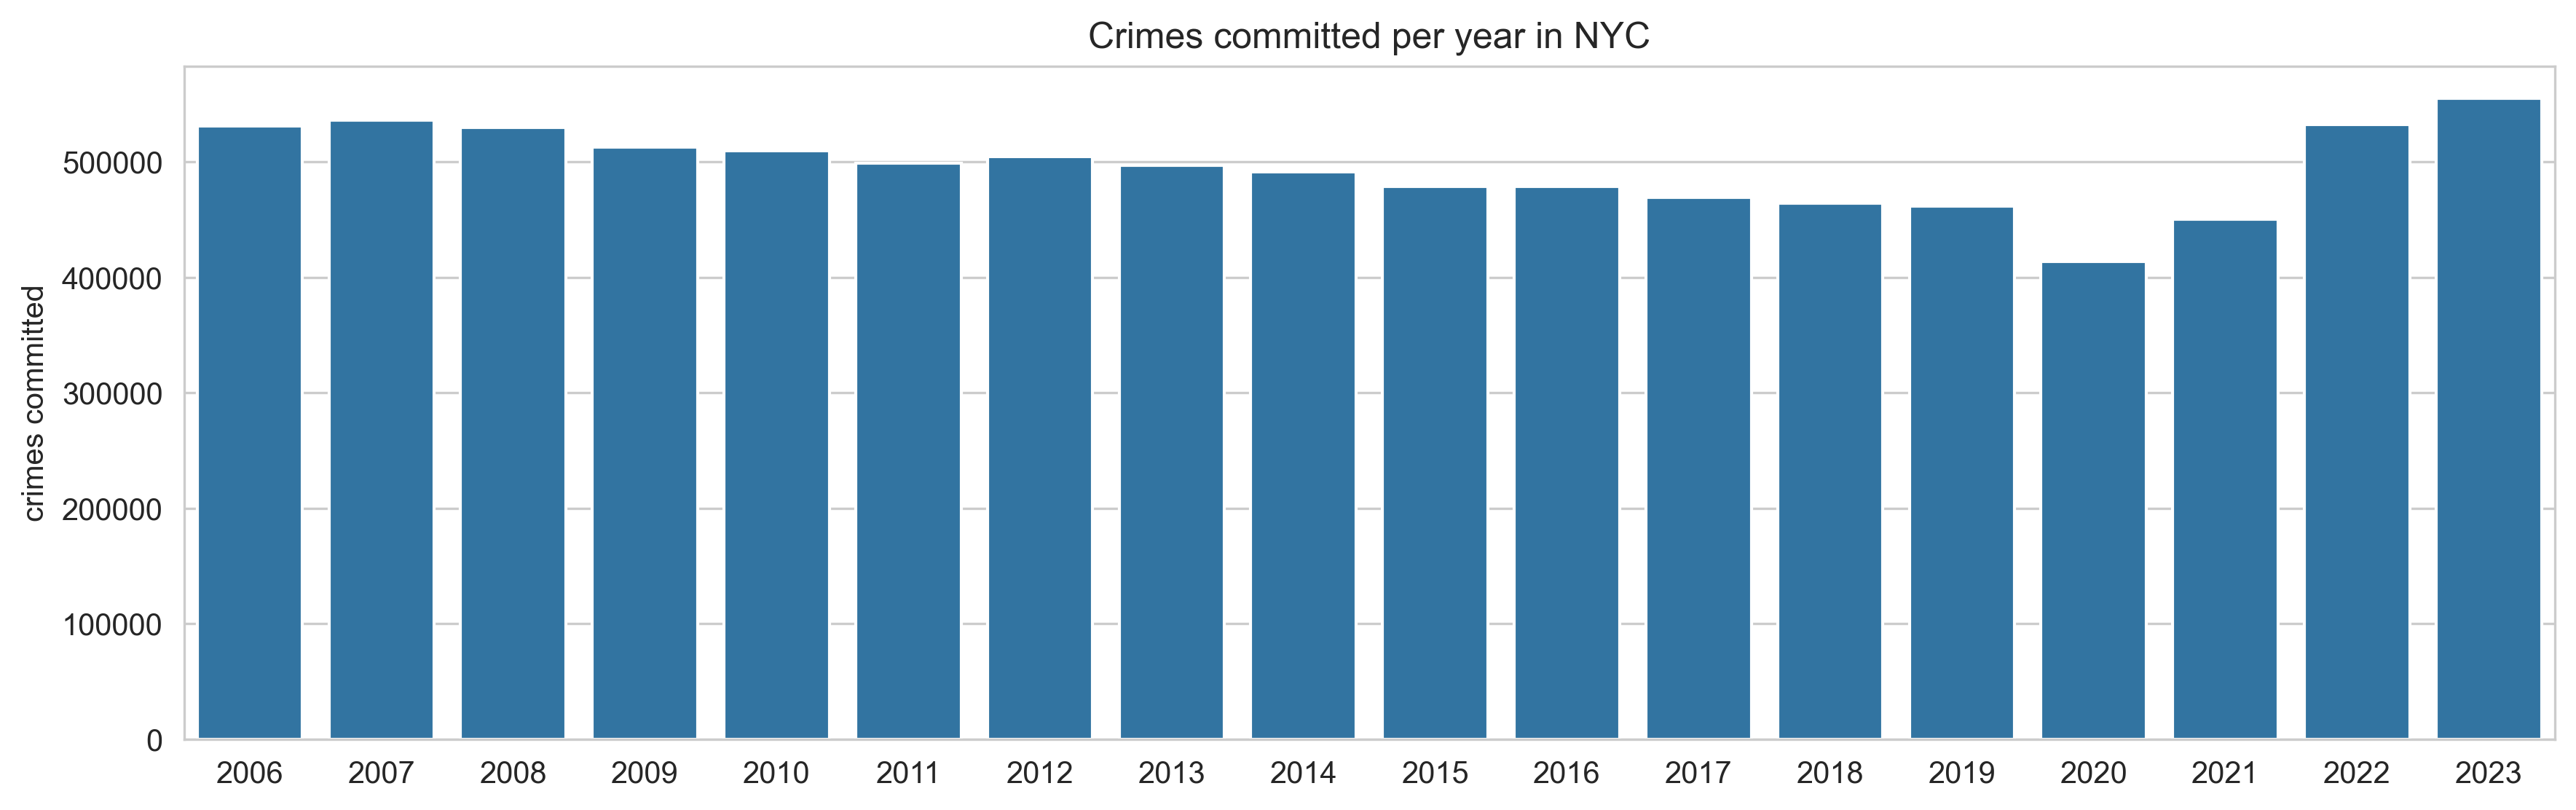

In [113]:
# Number of crimes committed per year
crime_per_year = data.groupby(data['RPT_DT'].dt.year, observed=True).size()

fig, ax = plt.subplots(figsize=(14, 4), dpi=300)
sns.barplot(crime_per_year)
ax.set_xlabel('')
ax.set_ylabel('crimes committed')
ax.set_title('Crimes committed per year in NYC')
plt.show()

# Lowest crime rate in 2020 due to pandemic

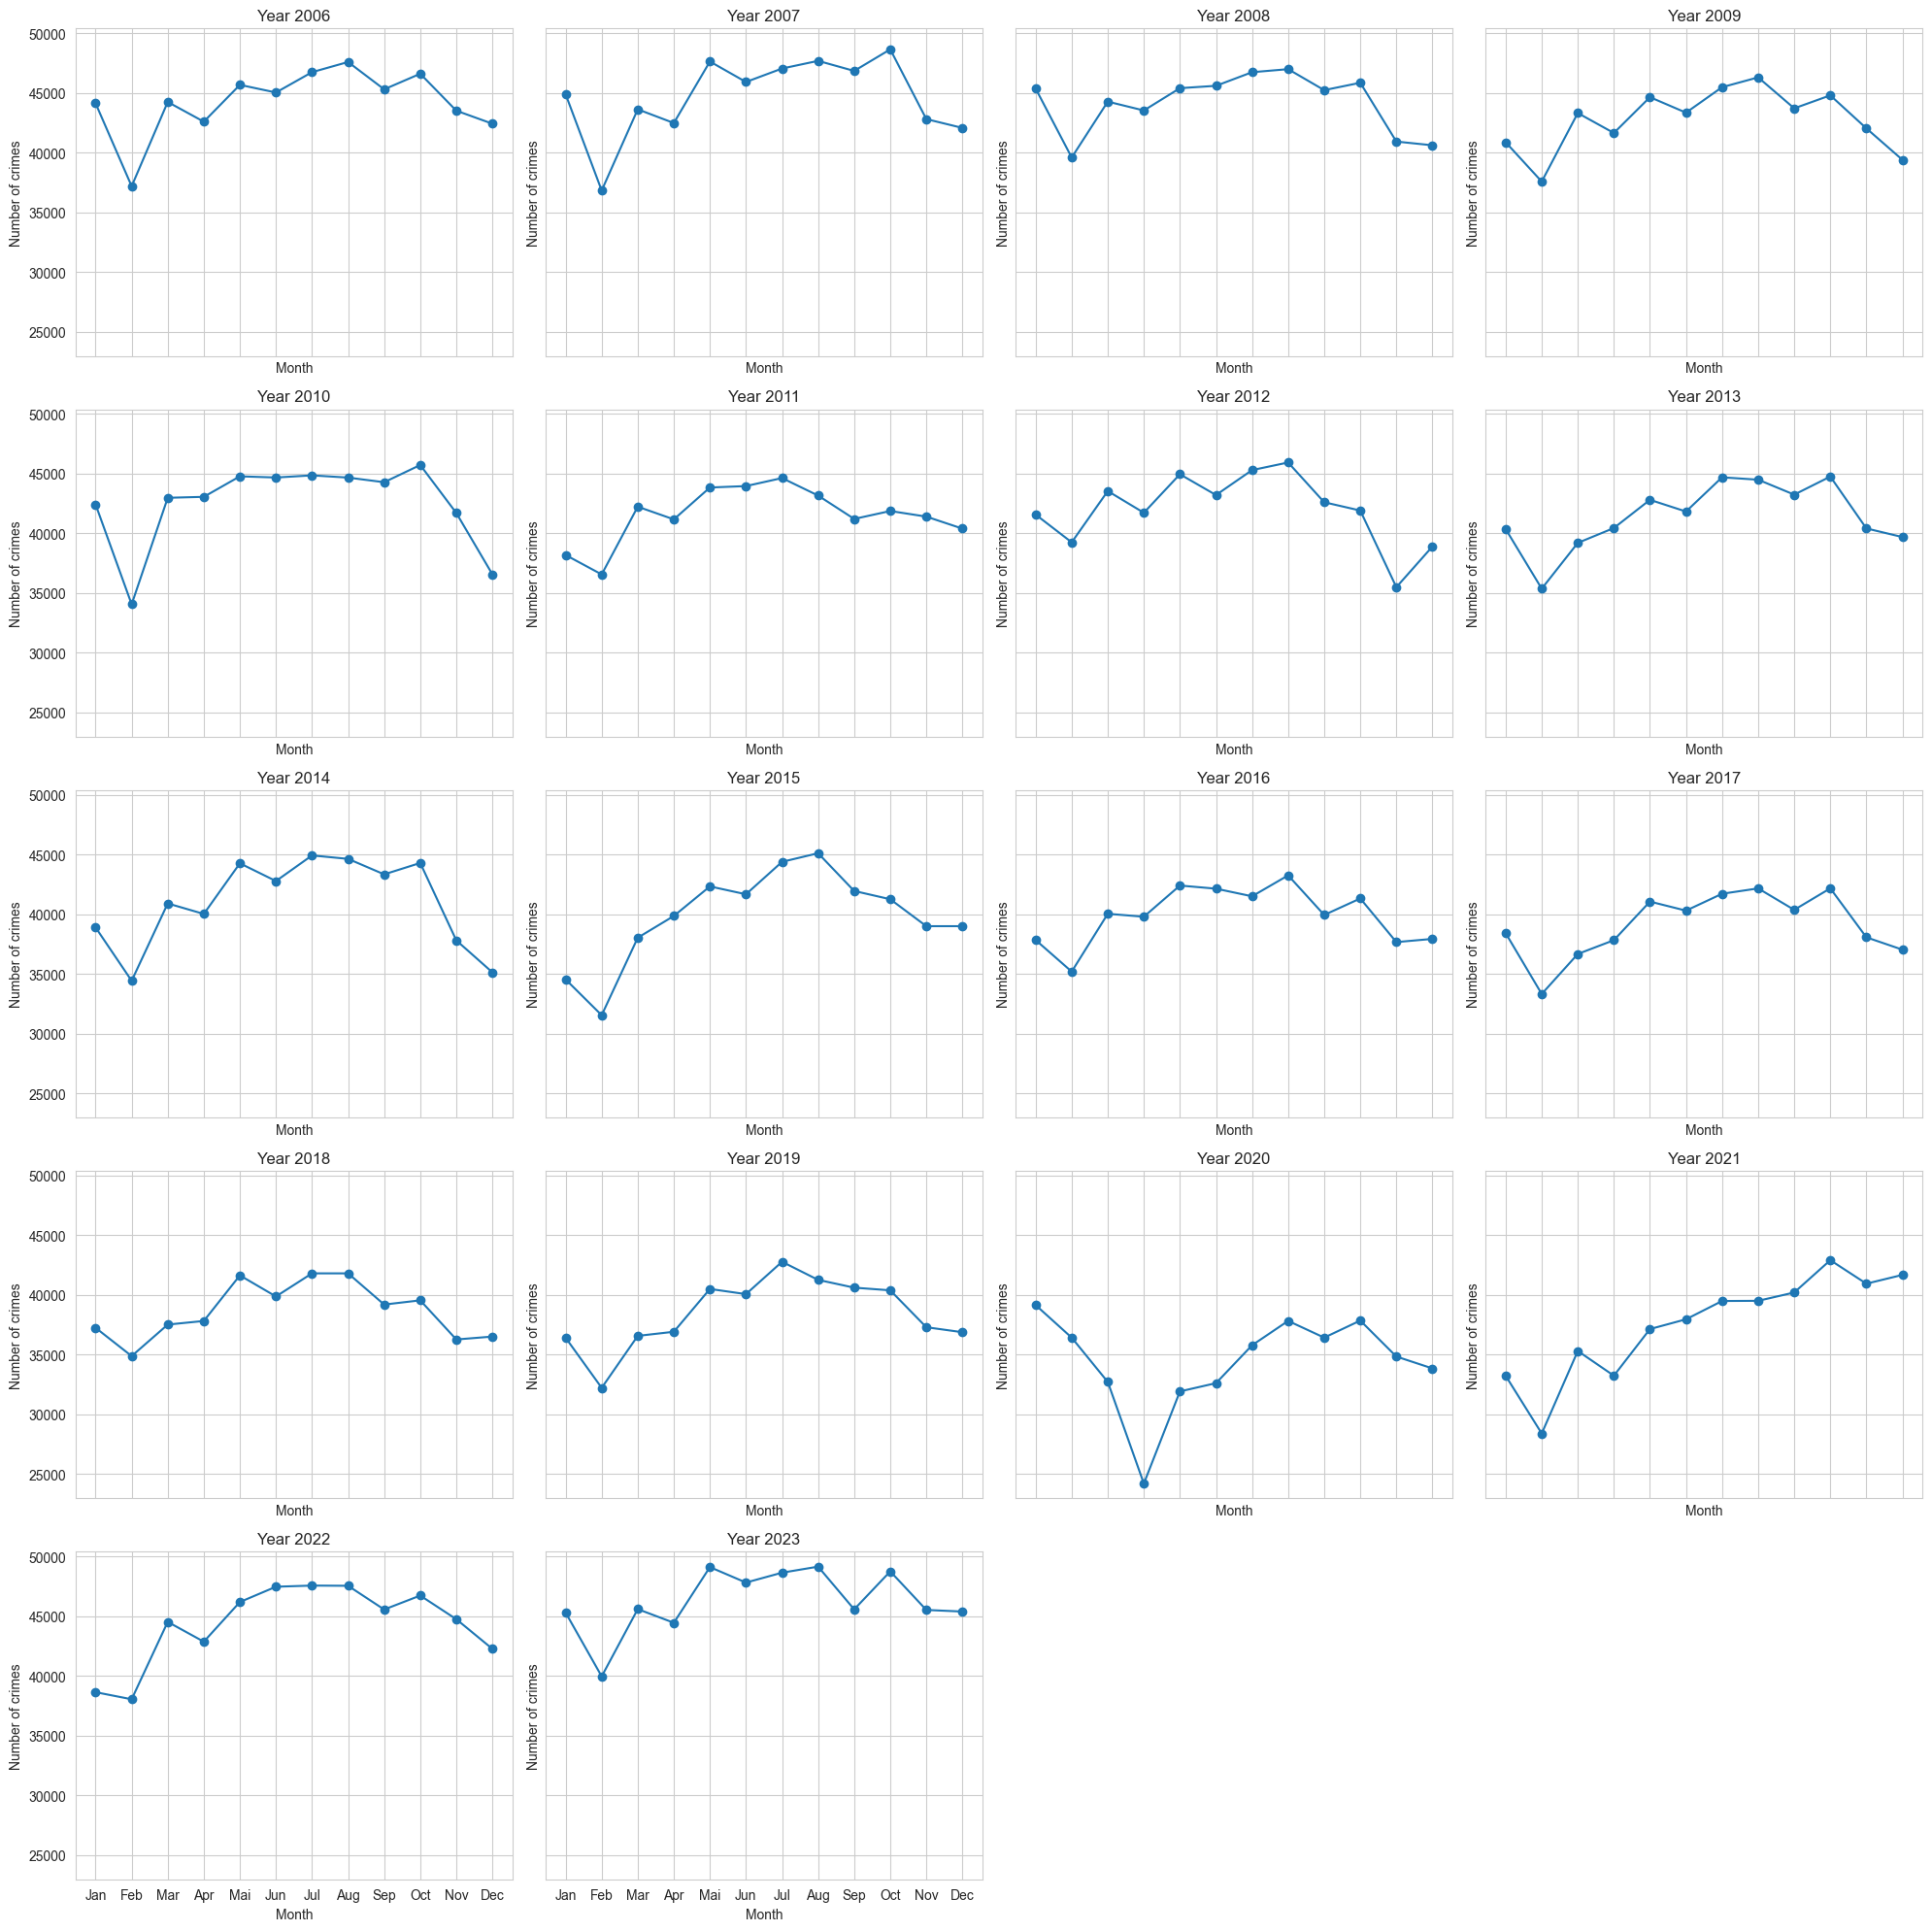

In [150]:
seasonal_trends = data.groupby([data['RPT_DT'].dt.year, data['RPT_DT'].dt.month]).size().unstack().fillna(0)

# Creating subplots
years = seasonal_trends.index
months = seasonal_trends.columns
num_years = len(years)

fig, axes = plt.subplots(nrows=num_years//4+1, ncols=4, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    ax.plot(months, seasonal_trends.loc[year], marker='o')
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of crimes')
    ax.set_xticks(months)
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Removing empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Visible drop when pandemic hit

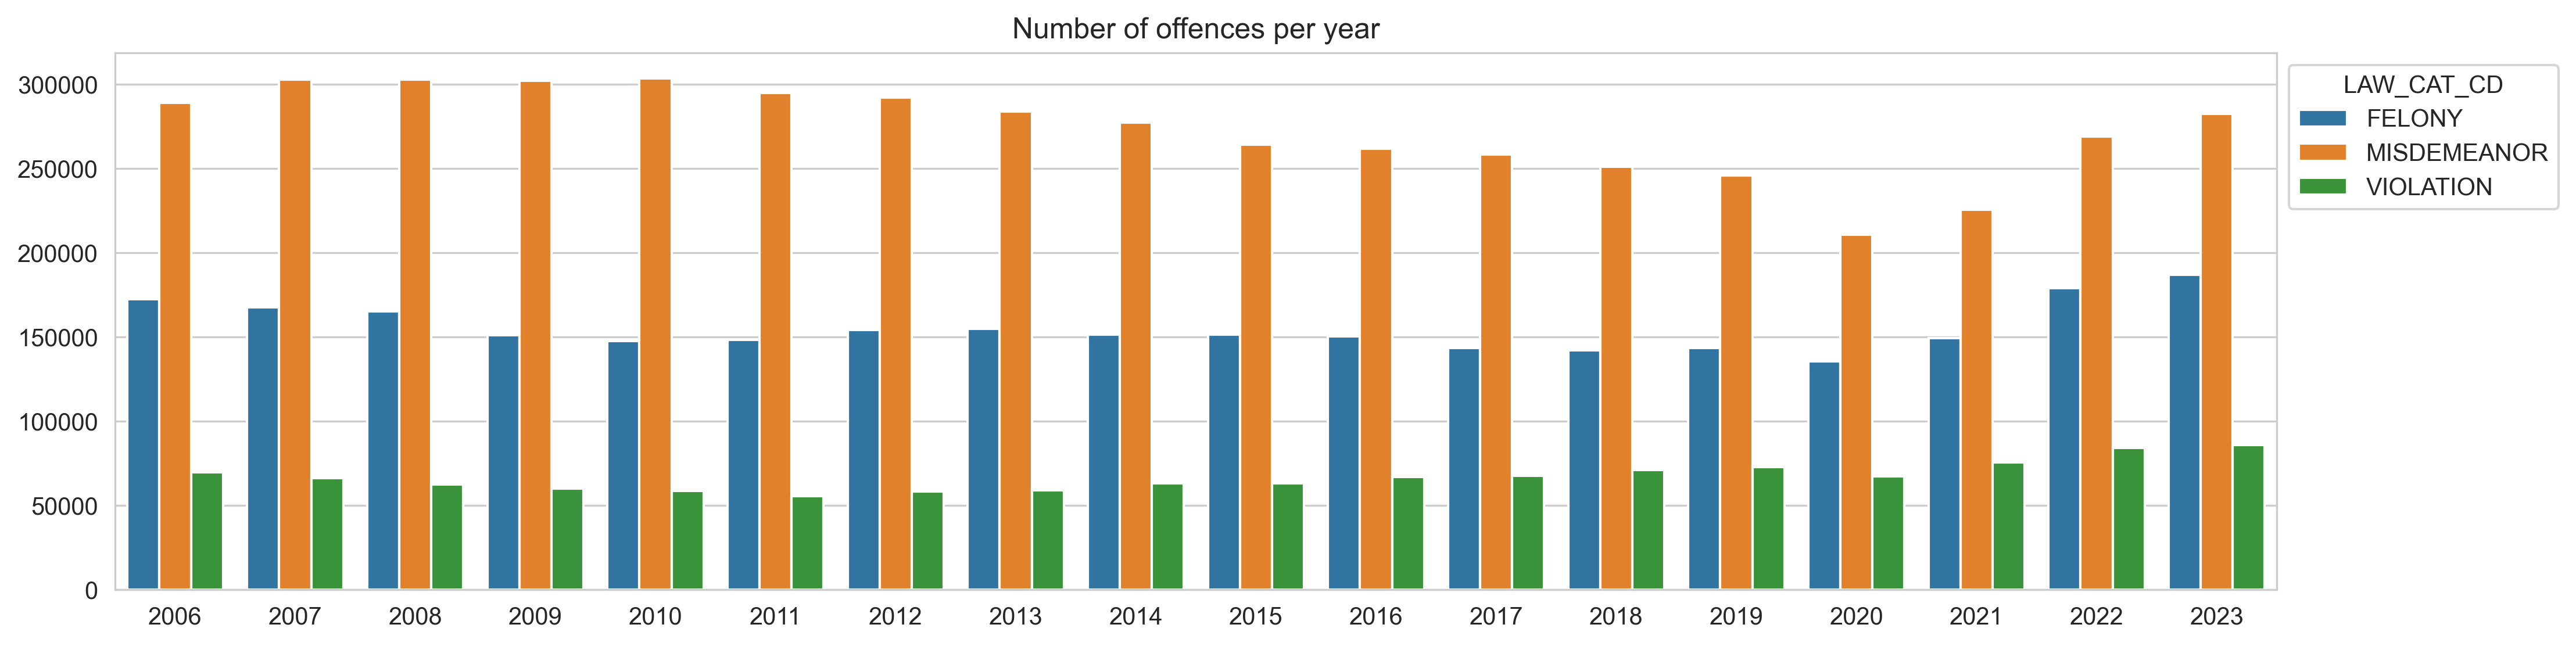

In [114]:
# Number of different level offences per year
offence_level_per_year = data.groupby([data['RPT_DT'].dt.year, 'LAW_CAT_CD'], observed=True).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
sns.barplot(data=offence_level_per_year, x='RPT_DT', y='count', hue='LAW_CAT_CD', ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Number of offences per year')
plt.show()

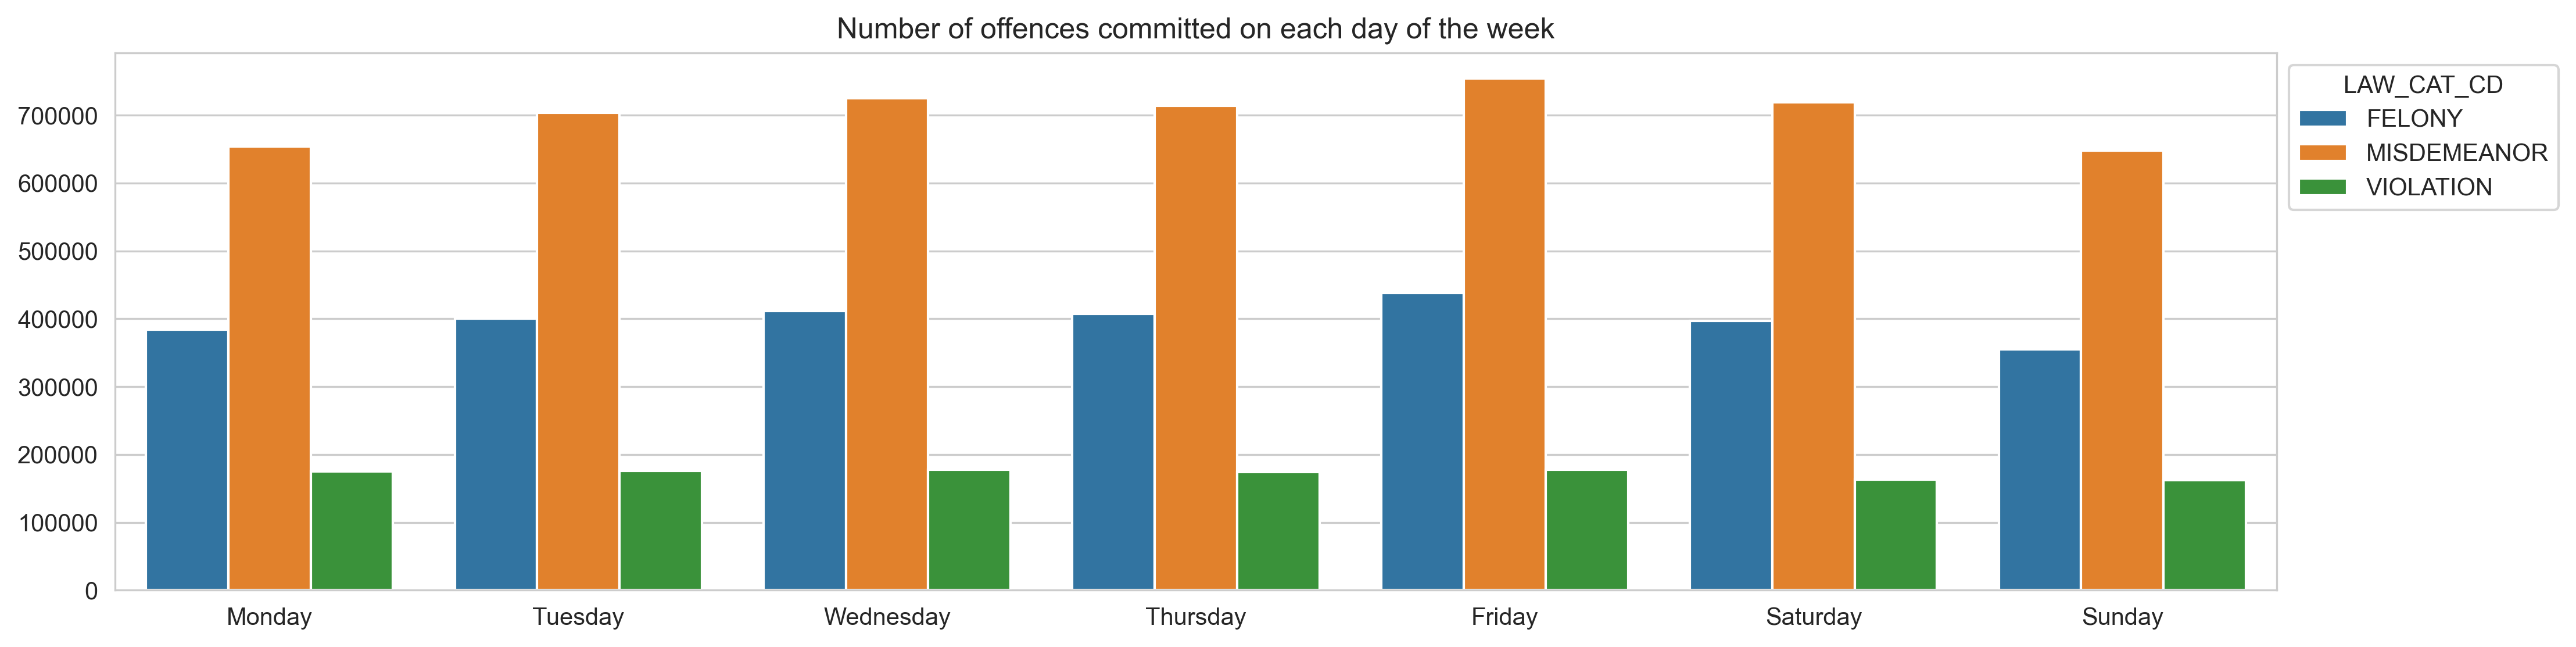

In [115]:
# Number of different level offences per day of week
offence_level_per_year = data.groupby(['DAY_OF_WEEK', 'LAW_CAT_CD'], observed=True).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
sns.barplot(data=offence_level_per_year, x='DAY_OF_WEEK', y='count', hue='LAW_CAT_CD', ax=ax, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Number of offences committed on each day of the week')
plt.show()

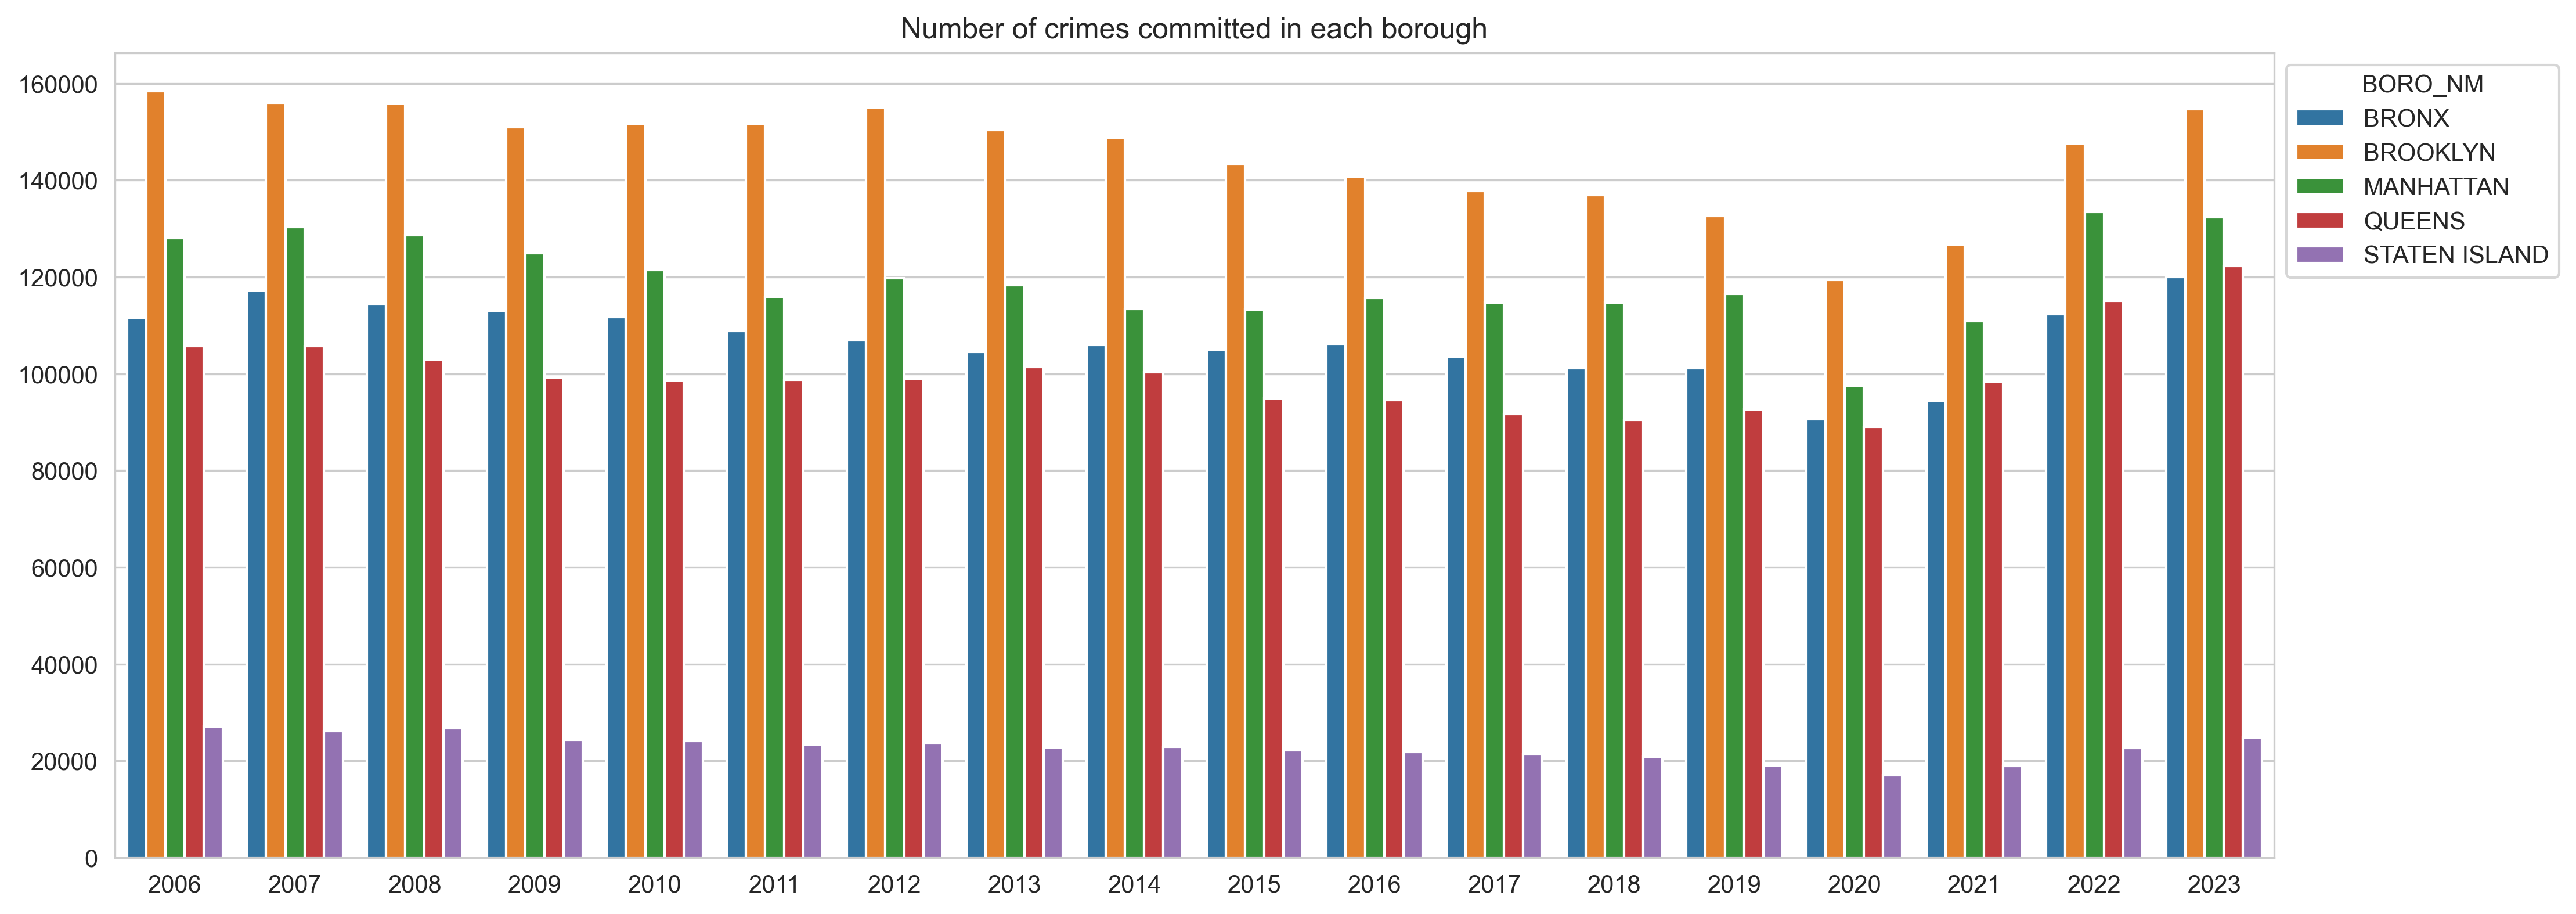

In [116]:
# Number of crimes committed in each borough
crime_by_borough = data.groupby([data['RPT_DT'].dt.year, 'BORO_NM'], observed=True).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(16, 6), dpi=300)
sns.barplot(data=crime_by_borough, x='RPT_DT', y='count', hue='BORO_NM')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Number of crimes committed in each borough')
plt.show()

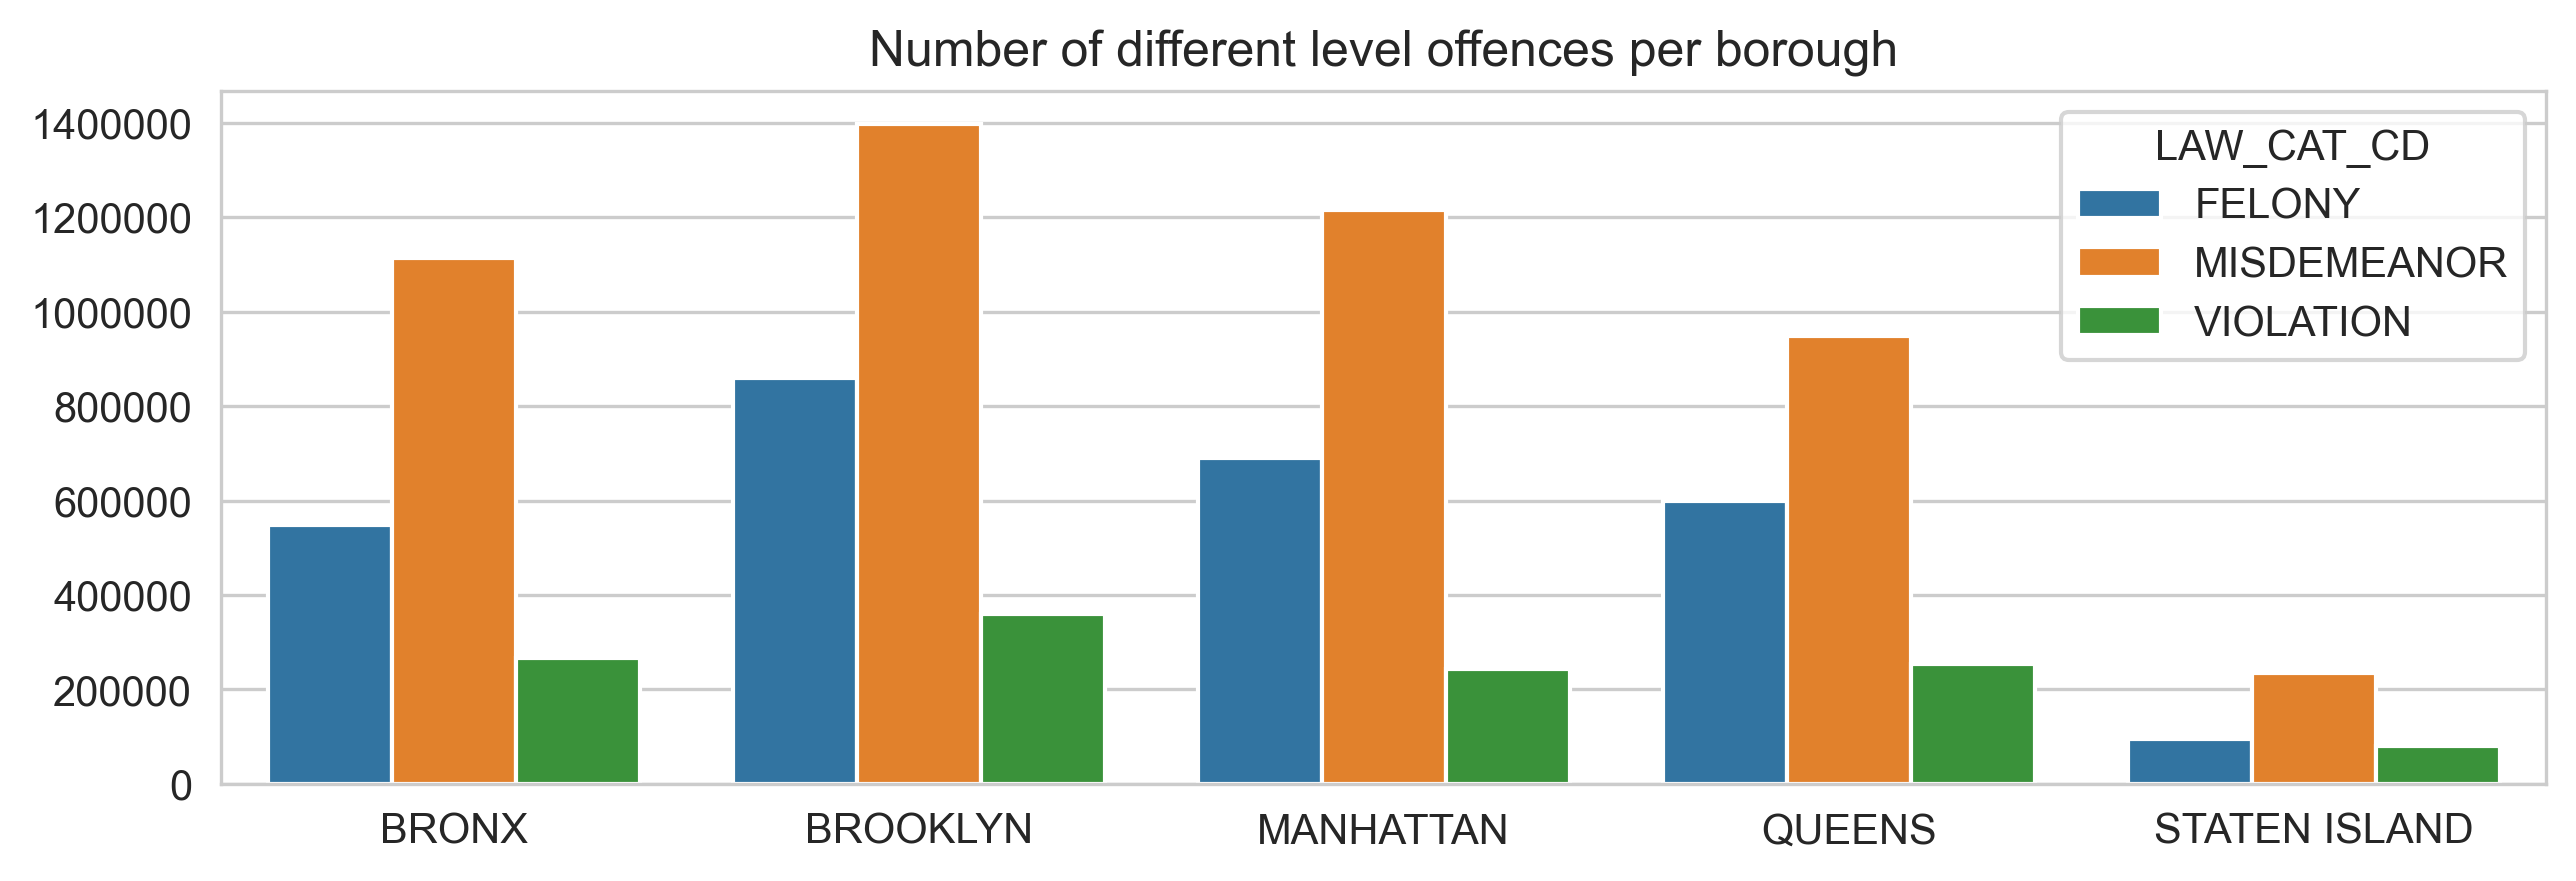

In [136]:
# Number of different level offences per borough
offense_type_by_borough = data.groupby(['LAW_CAT_CD', 'BORO_NM'], observed=True).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
sns.barplot(data=offense_type_by_borough, x='BORO_NM', y='count', hue='LAW_CAT_CD', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Number of different level offences per borough')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

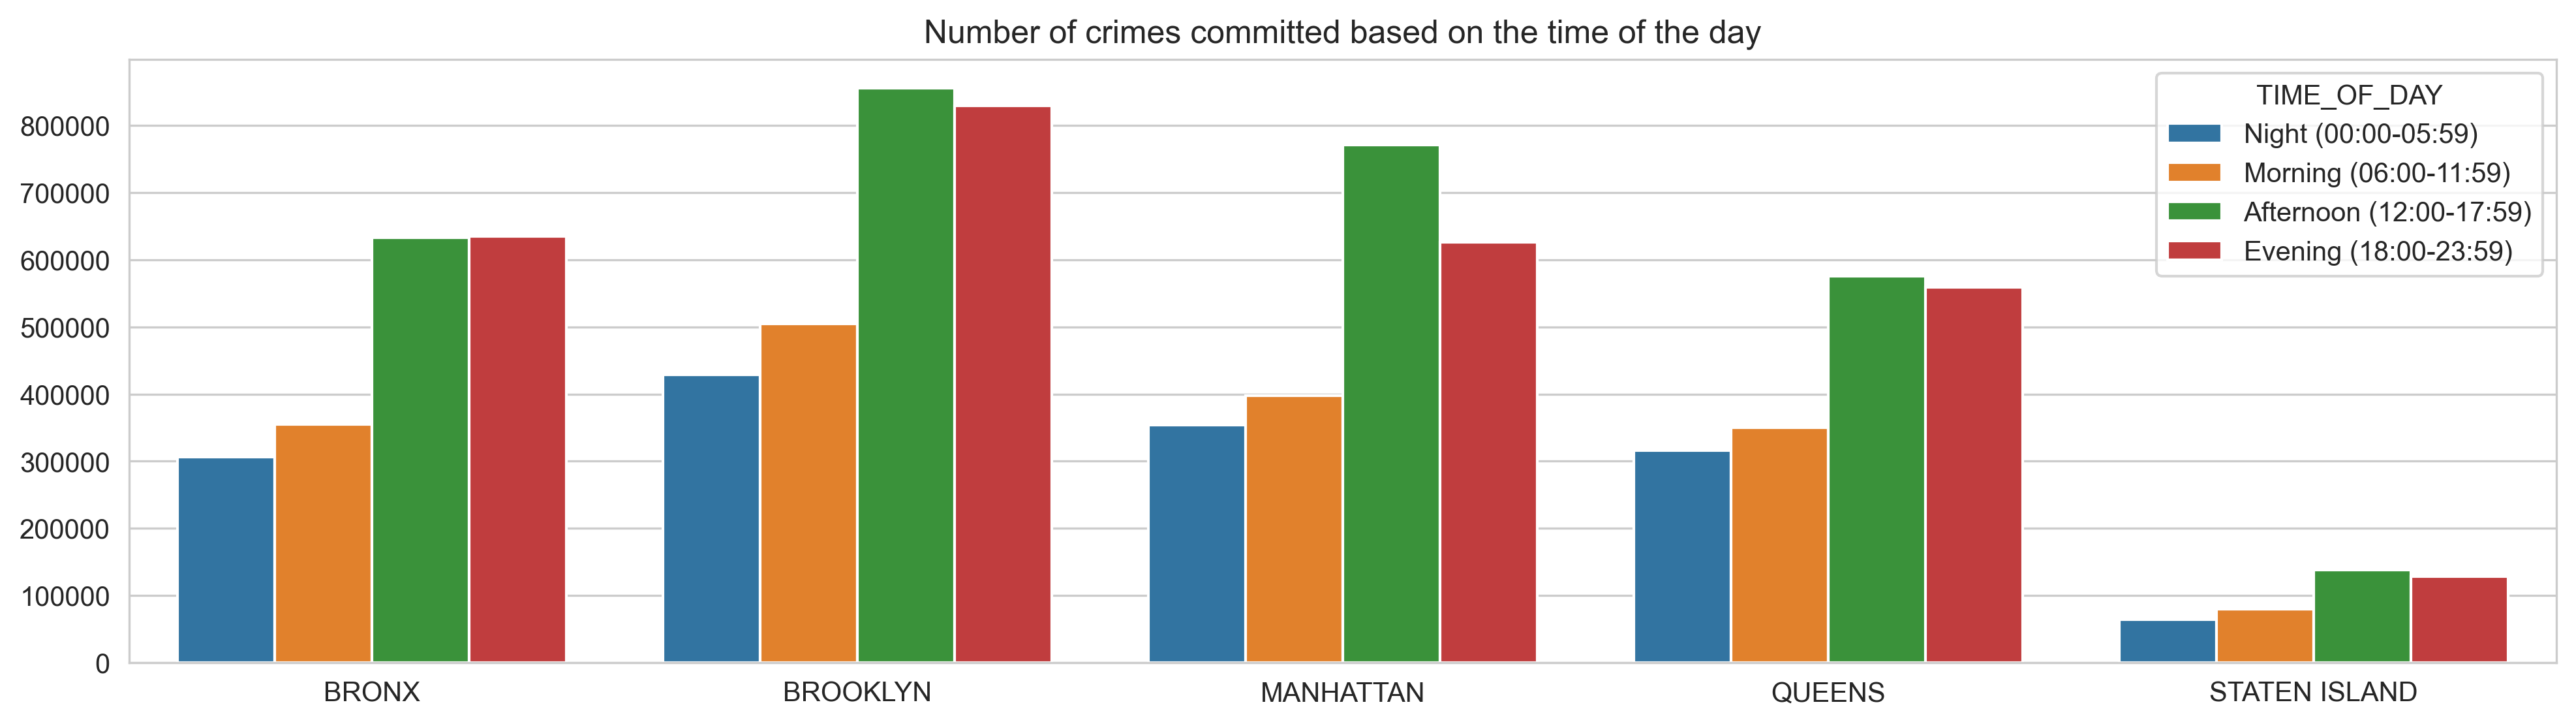

In [135]:
crime_per_time_of_day = data.groupby(['TIME_OF_DAY', 'BORO_NM'], observed=True).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
sns.barplot(data=crime_per_time_of_day, x='BORO_NM', y='count', hue='TIME_OF_DAY', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Number of crimes committed based on the time of the day')
plt.show()

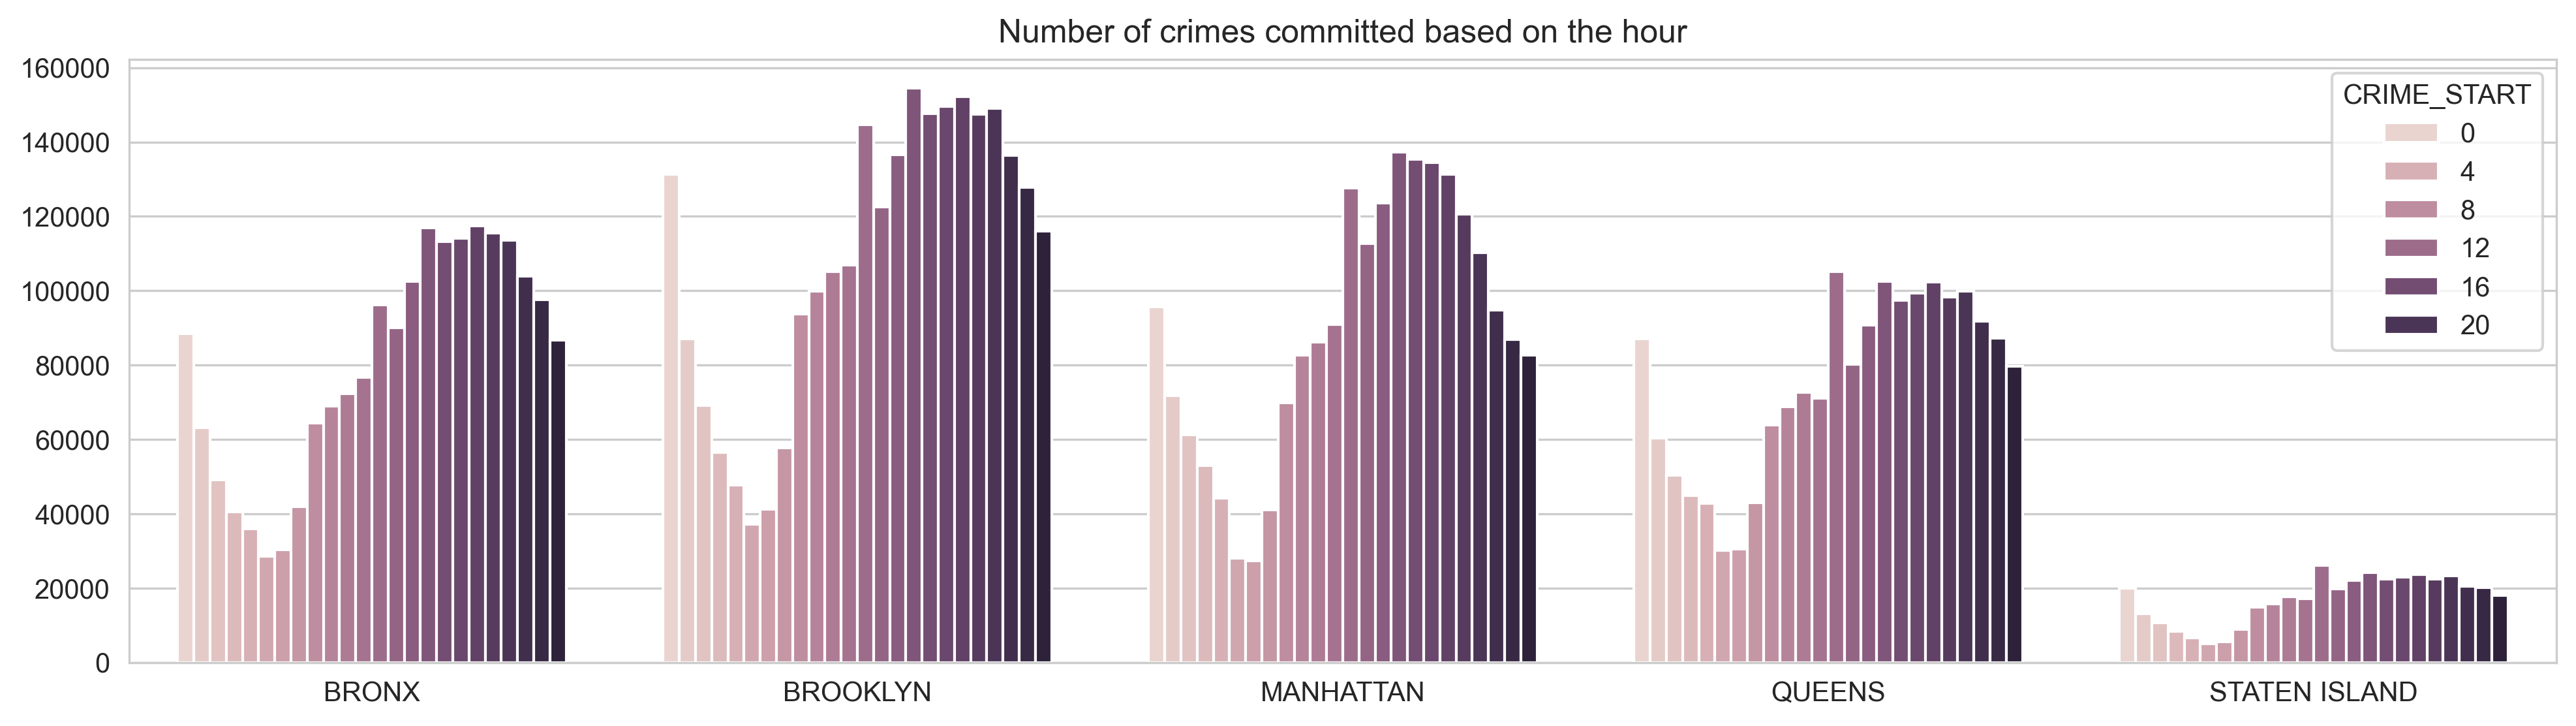

In [133]:
crime_per_hour = data.groupby([data['CRIME_START'].dt.hour, 'BORO_NM'], observed=True).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
sns.barplot(data=crime_per_hour, x='BORO_NM', y='count', hue='CRIME_START', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Number of crimes committed based on the hour')
plt.show()

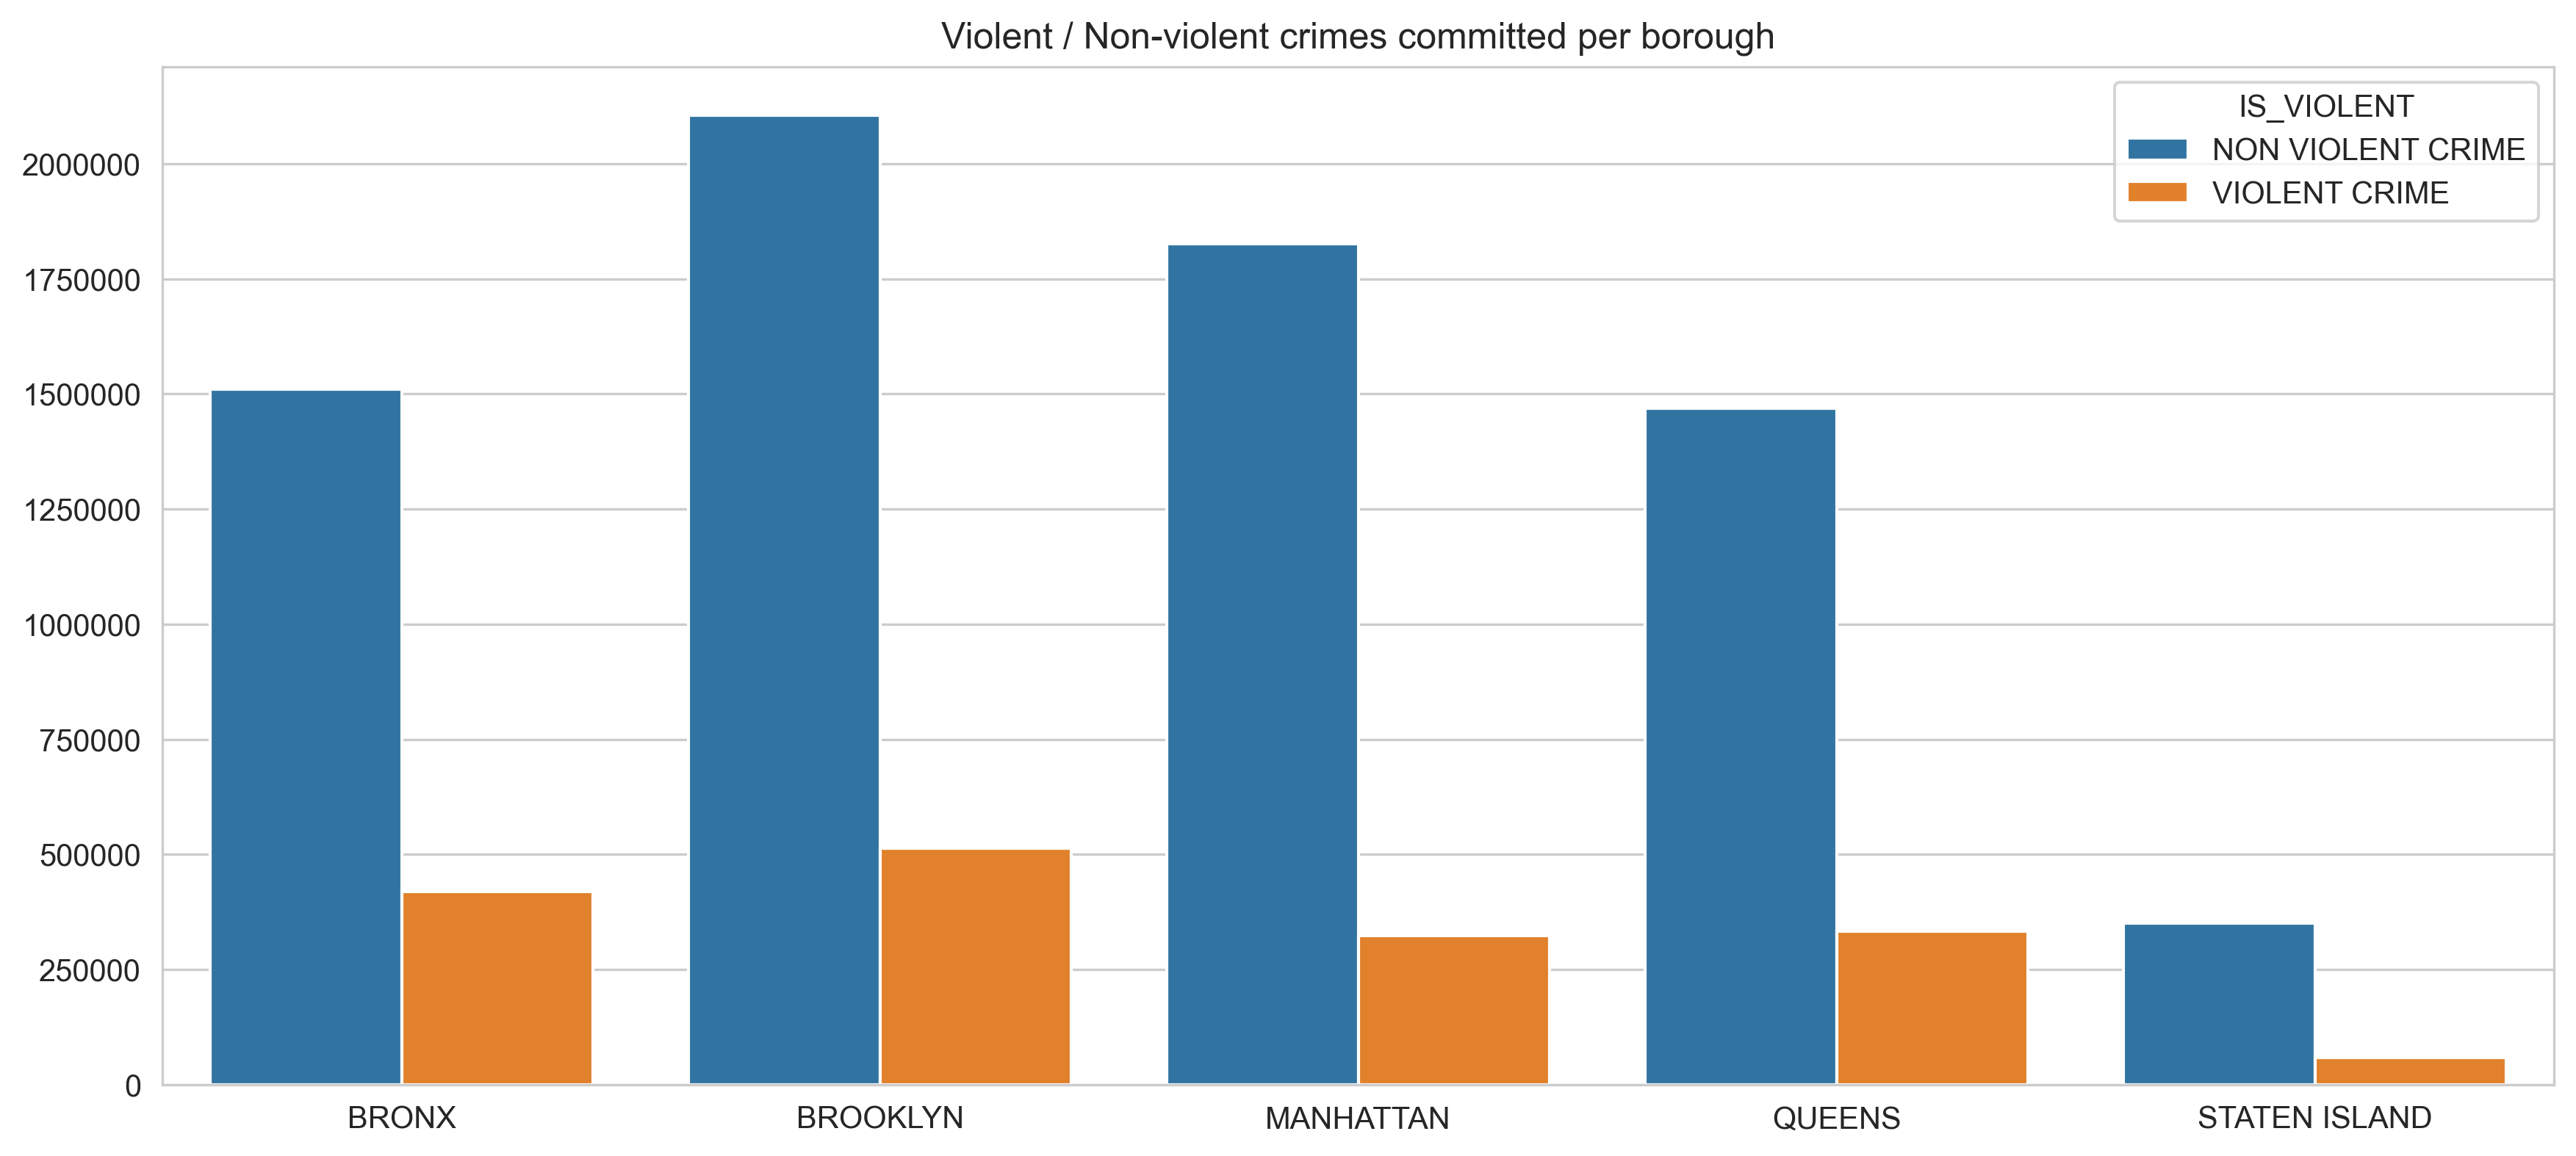

In [134]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

violent_crimes_per_borough = data.groupby(['IS_VIOLENT', 'BORO_NM'], observed=True).size().reset_index(name='count')
sns.barplot(data=violent_crimes_per_borough, x='BORO_NM', y='count', hue='IS_VIOLENT', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Violent / Non-violent crimes committed per borough')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

<h2>Visualizations telling the story</h2>

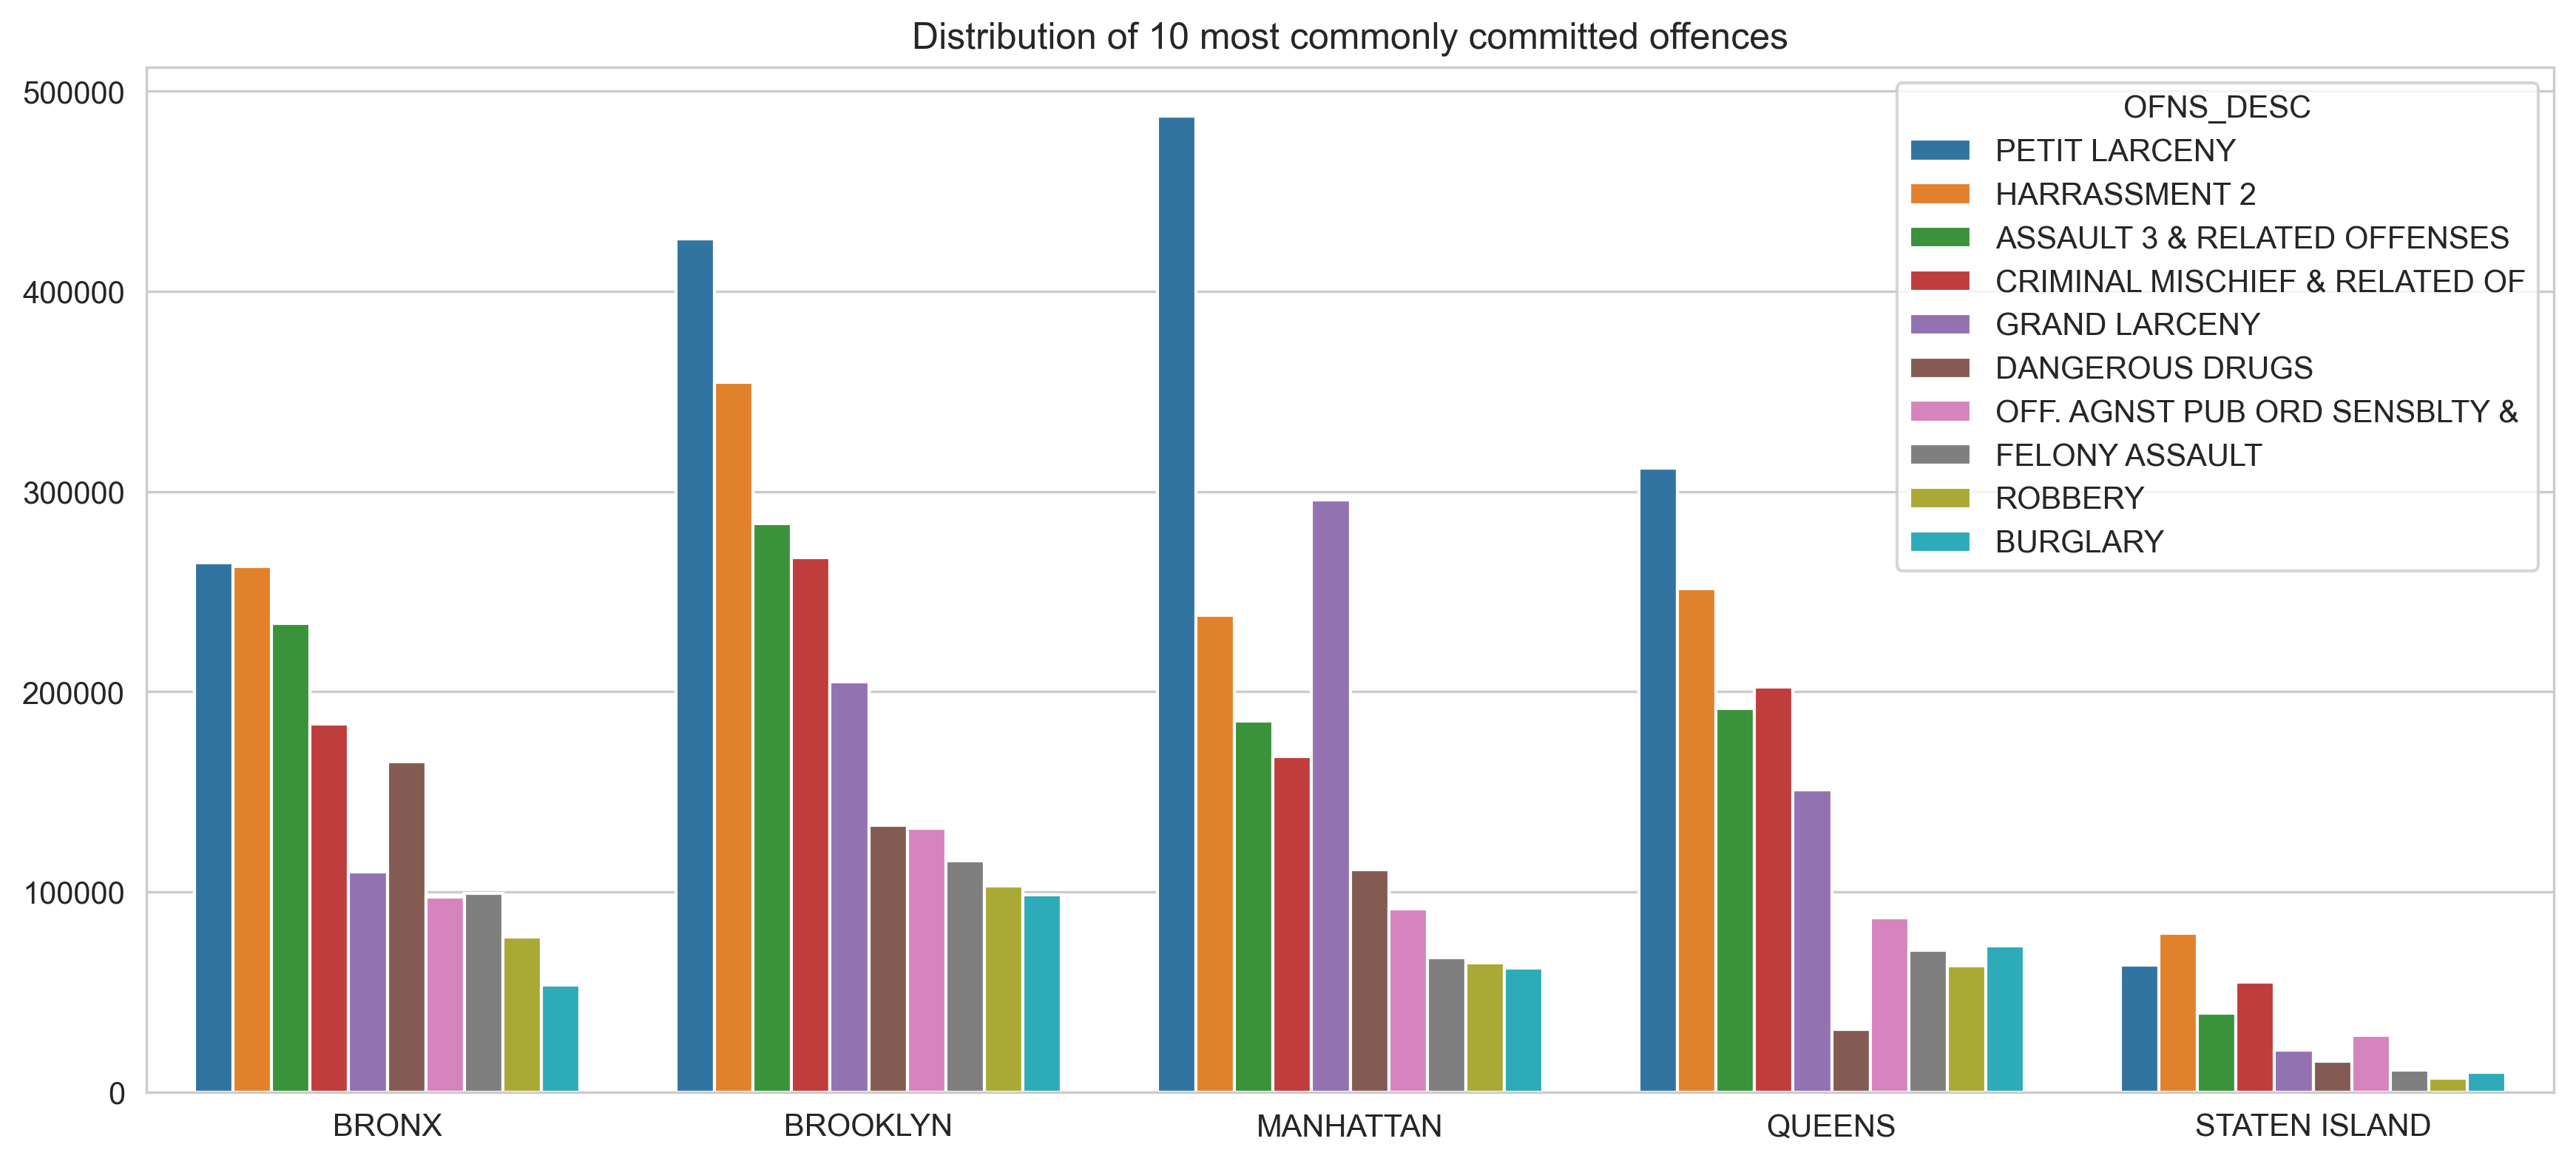

In [64]:
most_common_offences_list = list(data['OFNS_DESC'].value_counts().index[:10])
most_common_offences_df = data.loc[data['OFNS_DESC'].isin(most_common_offences_list)]

most_common_offences_per_borough = most_common_offences_df.groupby(['OFNS_DESC', 'BORO_NM'], observed=True).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
sns.barplot(data=most_common_offences_per_borough, x='BORO_NM', y='count', hue='OFNS_DESC', ax=ax, hue_order=most_common_offences_list)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Distribution of 10 most commonly committed offences')
plt.show()

In [132]:
import plotly.express as px

crime_location = data.groupby(['BORO_NM', 'OFNS_DESC'], observed=True).size().unstack(fill_value=0)
y_nticks = len(data['BORO_NM'].unique()) - 1

fig = px.imshow(crime_location, 
                labels=dict(x="Offence description", y="Borough", color="Number of committed crimes"),
                x=crime_location.columns, y=crime_location.index,
                title="Interactive heatmap of relation between offences and boroughs")
fig.update_layout(
    xaxis={'tickangle': 55},
    yaxis_nticks=y_nticks
)
fig.show()

<h3>Relation between types of committed crimes and borough wealth</h3>
<p>
When plotting most commonly committed offences in NYC with respect to the borough they were committed in it is easily observable that wealth of the area greatly influences the type of committed crimes. Manhattan and Bronx are the perfect example, Manhattan being the wealthiest borough according to median household income in 2018 (https://furmancenter.org/stateofthecity/view/citywide-and-borough-data) and Bronx being the poorest. In Manhattan there is a much larger number of larcenies, whereas in Bronx violent crimes such as assault or robbery as well as drug related offences are more common.
</p>

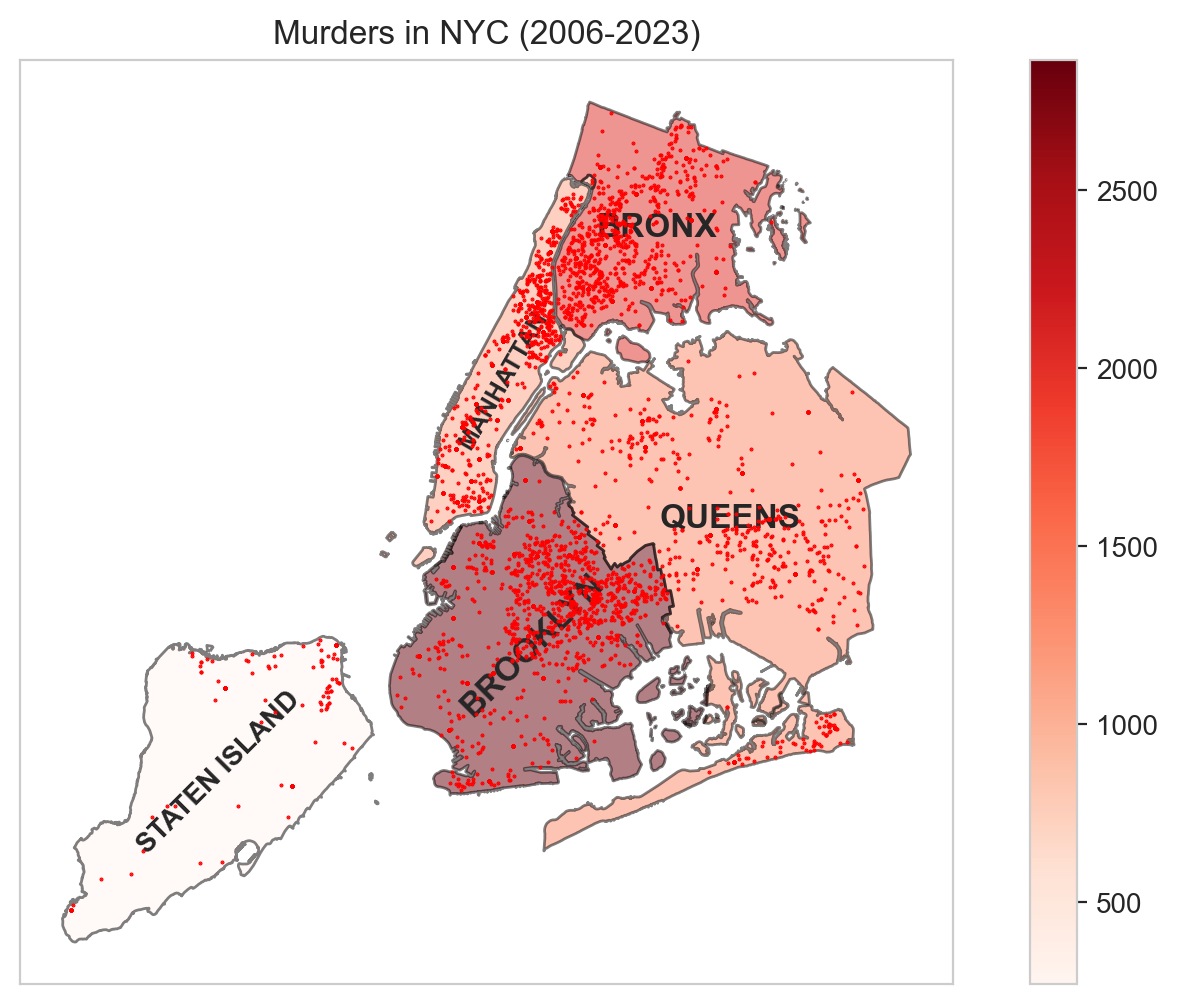

In [66]:
import geopandas
import geodatasets

# Map of murders

# Read NYC borough borders data into pandas dataframe
# Imported geo data is the same type as X_COORD_CD and Y_COORD_CD which are coordinates for New York State Plane Coordinate System (units feet)
nyc_map = geopandas.read_file(geodatasets.get_path('nybb'))[['BoroName', 'geometry']]
nyc_map = nyc_map.rename(columns={'BoroName': 'BORO_NM'})
nyc_map = nyc_map.replace({'Bronx': 'BRONX', 'Brooklyn': 'BROOKLYN', 'Manhattan': 'MANHATTAN', 'Queens': 'QUEENS', 'Staten Island': 'STATEN ISLAND'})

murder_data = data[data['OFNS_DESC'] == 'MURDER & NON-NEGL. MANSLAUGHTER']
murder_per_borough = murder_data.groupby('BORO_NM', observed=True).size().reset_index(name='count')
merged = pd.merge(nyc_map, murder_per_borough, on='BORO_NM')

borough_center = [p.centroid for p in list(merged['geometry'])]
borough_name = list(merged['BORO_NM'])
text_options = [{'size': 10, 'rotation': 45}, {'size': 12, 'rotation': 0}, {'size': 12, 'rotation': 45}, {'size': 9, 'rotation': 60}, {'size': 12, 'rotation': 0}]

murder_data.loc[murder_data['X_COORD_CD'] == 0, 'X_COORD_CD'] = np.NaN
murder_data.loc[murder_data['Y_COORD_CD'] == 0, 'Y_COORD_CD'] = np.NaN

fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)
merged.plot(ax=ax, column='count', alpha=0.5, cmap='Reds', edgecolor='k', legend=True, zorder=0)
for point, name, options in zip(borough_center, borough_name, text_options):
    plt.text(point.x, point.y, name, horizontalalignment='center', verticalalignment='center', 
             size=options['size'], rotation=options['rotation'], fontweight='semibold', zorder=1)

ax.scatter(murder_data['X_COORD_CD'], murder_data['Y_COORD_CD'], s=0.2, color='red', zorder=2)
ax.set_title('Murders in NYC (2006-2023)', fontsize=12)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

<h3>Relation between murders and gang activity</h3>
<p>
There are two noticeably larger clusters. First in east Harlem/south Bronx and the second one in Brownsville/Bushwick in central Brooklyn. Both of these neighborhoods are infamous for high gang activity. Map of murders might be a solid indicator of areas with organized crime.
</p>

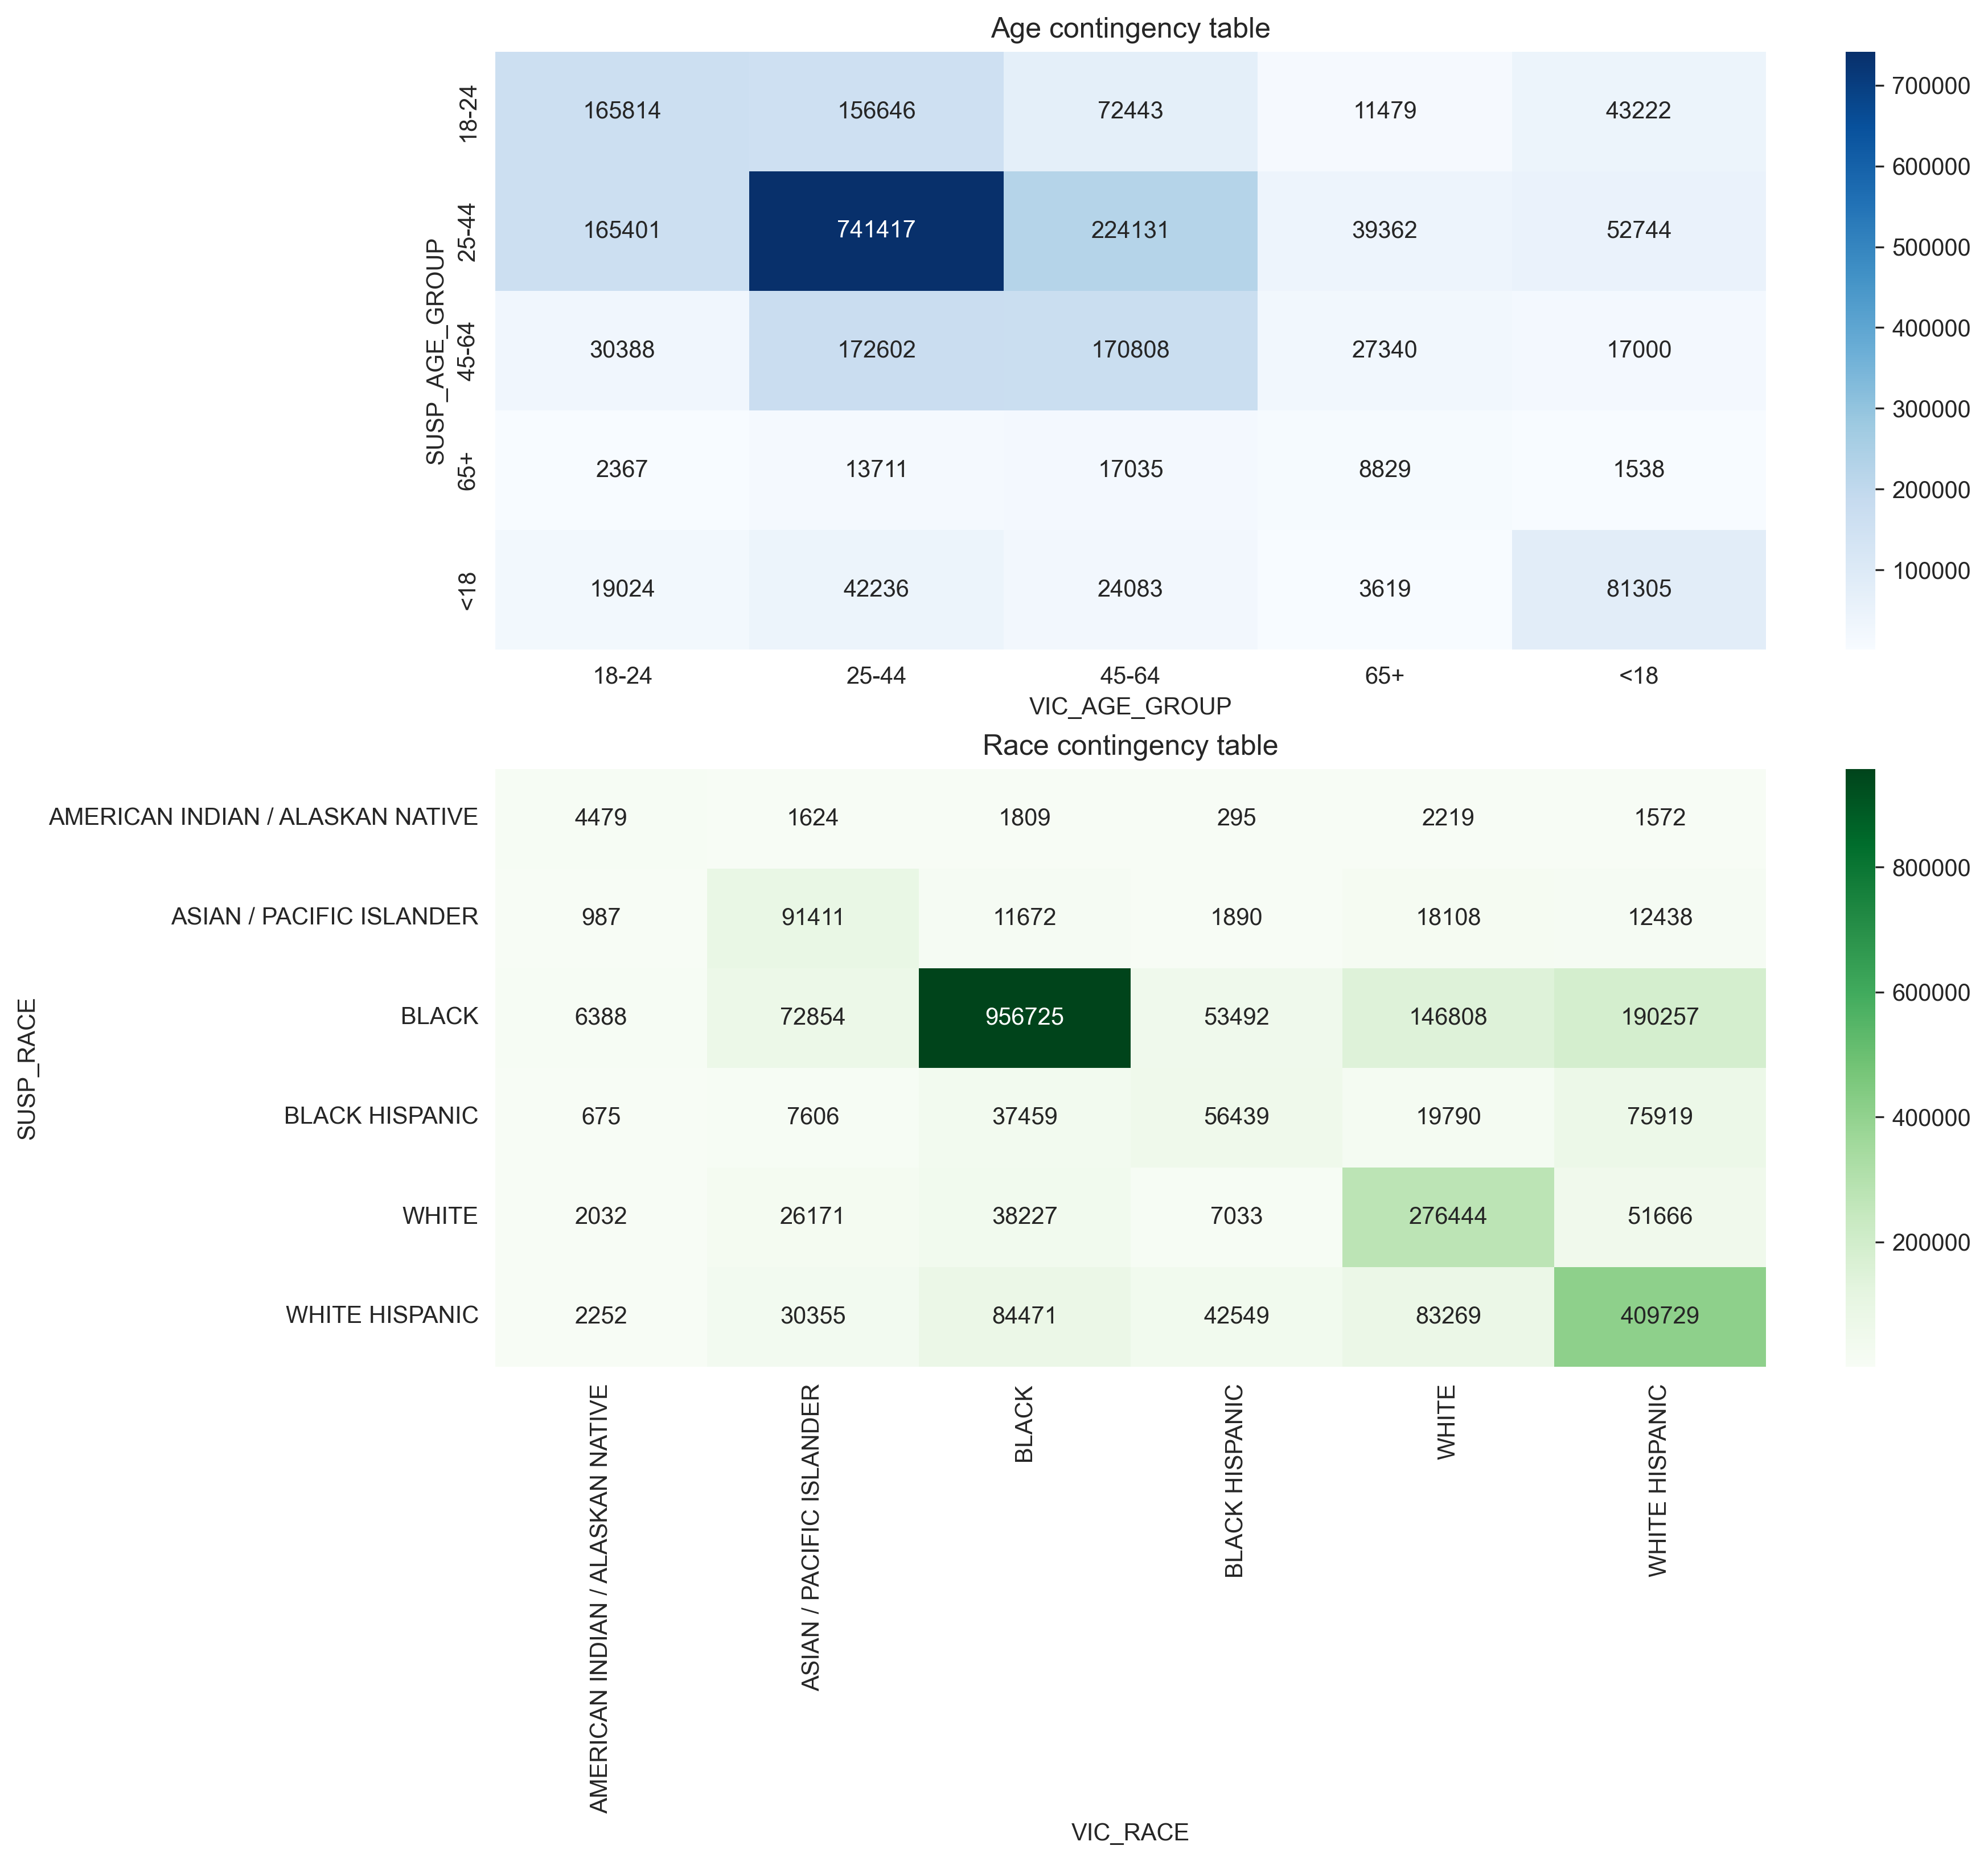

In [151]:
susp_vic_age = pd.crosstab(data['SUSP_AGE_GROUP'], data['VIC_AGE_GROUP'])
susp_vic_race = pd.crosstab(data['SUSP_RACE'], data['VIC_RACE'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=300)
sns.heatmap(susp_vic_age, annot=True, fmt="d", cmap='Blues', ax=ax1)
ax1.set_title('Age contingency table')

sns.heatmap(susp_vic_race, annot=True, fmt="d", cmap='Greens', ax=ax2)
ax2.set_title('Race contingency table')
plt.show()

<h3>Crime in the same demographic groups</h3>
<p>
It is noticeable that people are more likely to commit a crime against other members of the same demographic groups.
</p>

<h2>ML model</h2>

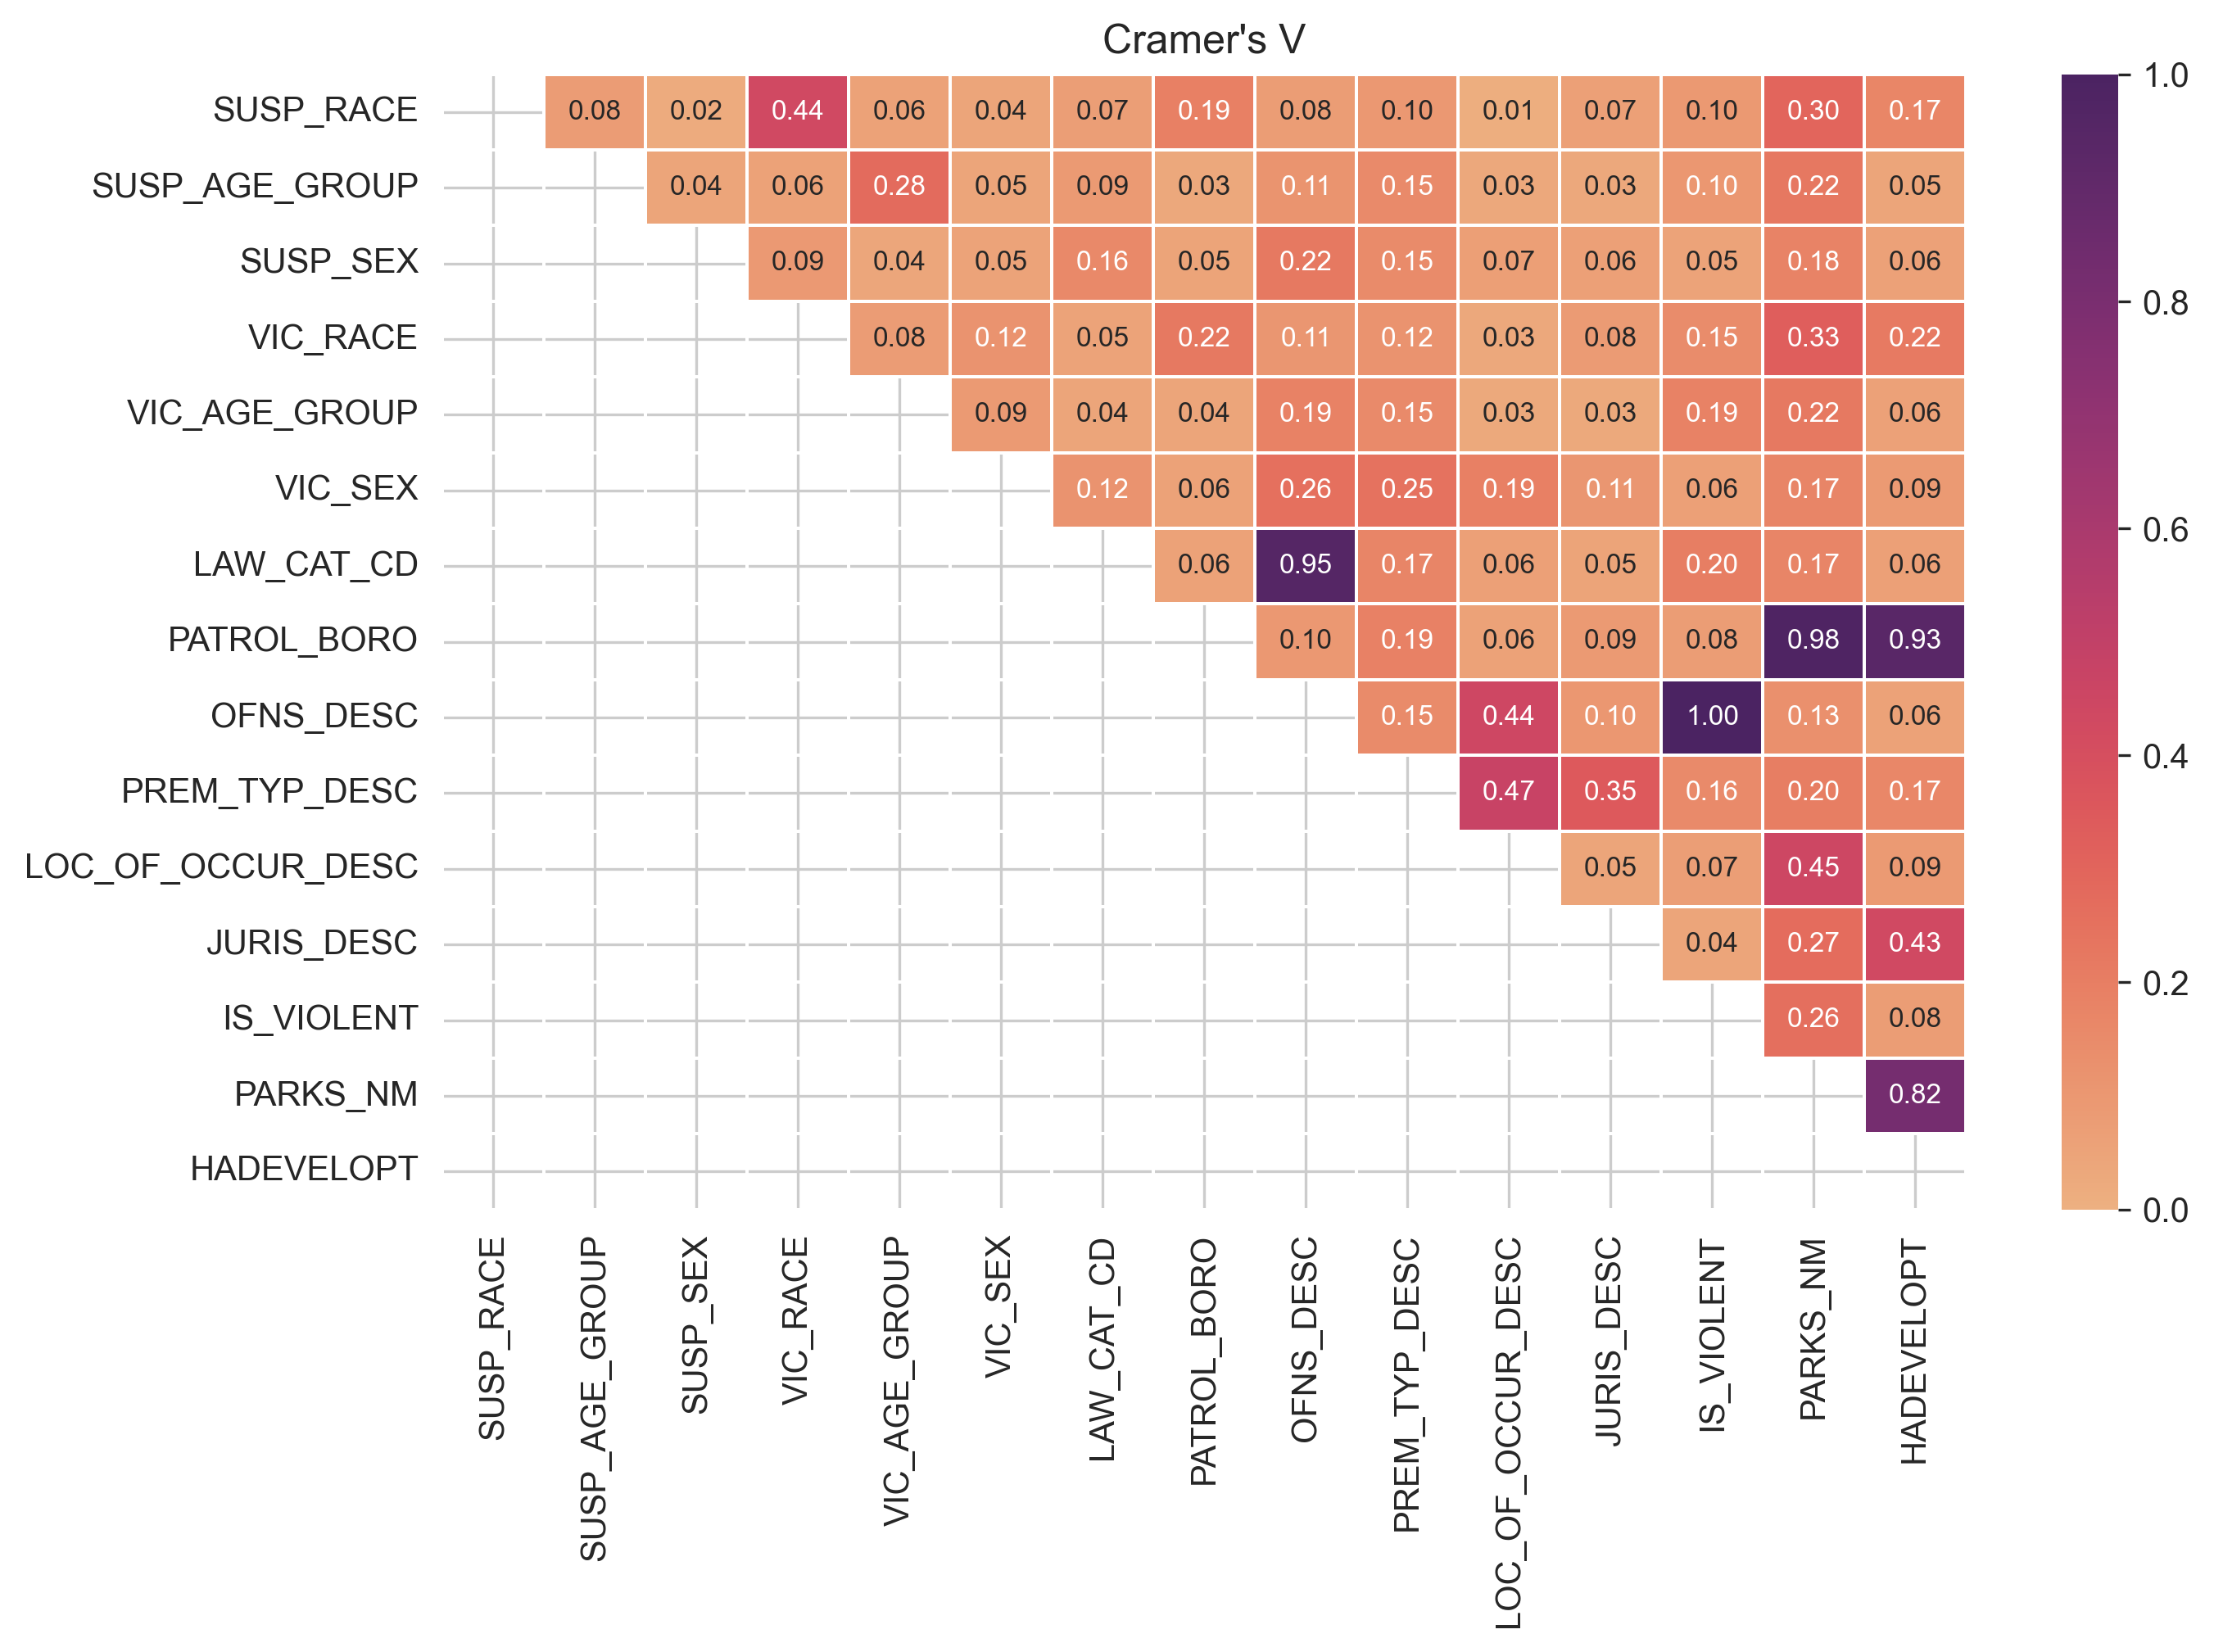

In [104]:
from scipy.stats import chi2_contingency
import itertools

# Cramer's V is a measure of association between 2 nominal variables. 
# It returns a value between 0 and 1 where 0 means no association between the variables and 1 means complete association

# Bias corrected Cramer's V 
def corrected_cramers_V(col1, col2, data):
    contingency_table = pd.crosstab(data[col1], data[col2])
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    r, k = contingency_table.shape
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corrected = r - ((r-1)**2)/(n-1)
    k_corrected = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corrected / min((k_corrected-1), (r_corrected-1)))

cols = ['SUSP_RACE', 'SUSP_AGE_GROUP', 'SUSP_SEX', 'VIC_RACE', 'VIC_AGE_GROUP', 'VIC_SEX', 'LAW_CAT_CD', 'PATROL_BORO', 'OFNS_DESC', 'PREM_TYP_DESC', 'LOC_OF_OCCUR_DESC', 'JURIS_DESC', 'IS_VIOLENT', 'PARKS_NM', 'HADEVELOPT']
cols_pairs = list(itertools.combinations(cols, 2))

results_df = pd.DataFrame(index=cols, columns=cols)
for (col1, col2) in cols_pairs:
    correlation = corrected_cramers_V(col1, col2, data)
    results_df.loc[col1, col2] = correlation

results_df = results_df.astype(float)

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
sns.heatmap(results_df, annot=True, cmap='flare', vmin=0, vmax=1, fmt='.2f', linewidths=0.5, annot_kws={"fontsize":8}, ax=ax)
ax.set_title("Cramer's V")
plt.show()

According to Cramer's V measure several variables are at least slightly associated with suspect race. It might be possible to predict race of the suspect using these variables in cases when victim was unable to identify it. Although in a problem like this, there may be a lot of exceptional cases (because it is technically possible for a suspect race to be different even though every feature is exactly the same in 2 different cases), hence the accuracy of the predictions may not be very high but it still might be helpful to the NYC police.

In [94]:
from sklearn.model_selection import train_test_split

# Preparing data for model training
# nullable_features is a list of features that may contain NaNs
# in other features rows with NaNs are dropped
def prep_cat_data(feature_names, target_name, data, nullable_features=None):
    df = data[[*feature_names, target_name]]
    if nullable_features is None:
        df = df.dropna()
    else:
        non_nullable_features = [feature for feature in feature_names if feature not in nullable_features]
        df = df.dropna(subset=[*non_nullable_features, target_name])
    df.is_copy = False
        
    labels = np.array(list(data[target_name].value_counts().index))
    label_mapping = {cat:i for i, cat in enumerate(labels)}
    
    X = df[feature_names]
    y = df[target_name].map(label_mapping)
    
    # 80/10/10
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
    return (X_train, X_val, X_test, y_train, y_val, y_test), labels

In [95]:
from sklearn.metrics import confusion_matrix

# Predicts probabilities for every class, chooses class with the highest probability, returns predicted class and it's probability
def predict(clf, X_val):
    prediction_prob = clf.predict_proba(X_val)
    prediction = np.argmax(prediction_prob, axis=1)
    model_confidence = prediction_prob[np.arange(prediction.shape[0]), prediction]
    return prediction, model_confidence

# Evaluates classifier on given dataset and plots confusion matrix
# Confidence threshold can be specified so that model will skip predictions in which it's not confident in
def eval_cat_model(clf, X_val, y_val, labels, confidence_threshold=0):
    print(f"size of validation split: {X_val.shape[0]}")
    prediction, model_confidence = predict(clf, X_val)
    confident_prediction = model_confidence > confidence_threshold
    out_confident_val, y_confident_val = prediction[confident_prediction], y_val[confident_prediction]
    print(f"number of confident predictions: {out_confident_val.shape[0]}")
    
    conf_matrix = confusion_matrix(y_confident_val, out_confident_val)
    n = out_confident_val.shape[0]
    accuracy = np.trace(conf_matrix) / n
    precision = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=1)
    f1_score = (2 * precision * recall) / (precision + recall)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}, mean: {precision.mean()}")
    print(f"Recall: {recall}, mean: {recall.mean()}")
    print(f"F1 score: {f1_score}, mean: {f1_score.mean()}")

    ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
    ax.set(xlabel='Predicted', ylabel='Actual')
    ax.xaxis.set_ticklabels(labels, rotation=90, wrap=True, fontsize=10, va='center', ha='right')
    ax.yaxis.set_ticklabels(labels, rotation=0, wrap=True, fontsize=10)
    ax.set_title('Confusion matrix', fontsize=18)

    plt.show()

In [105]:
non_nullable = ['VIC_RACE', 'VIC_AGE_GROUP', 'PATROL_BORO', 'PREM_TYP_DESC', 'LOC_OF_OCCUR_DESC', 'JURIS_DESC', 'IS_VIOLENT', 'OFNS_DESC']
nullable = ['PARKS_NM', 'HADEVELOPT']  # columns with a lot more NaNs than other features, so they can be nullable
features = [*non_nullable, *nullable]  # all features
target_name = 'SUSP_RACE'
(X_train_race, X_val_race, X_test_race, y_train_race, y_val_race, y_test_race), labels_race = prep_cat_data(features, target_name, data, nullable_features=nullable)

In [97]:
data['SUSP_RACE'].value_counts()

SUSP_RACE
BLACK                               1924910
WHITE HISPANIC                       875462
WHITE                                541585
BLACK HISPANIC                       270703
ASIAN / PACIFIC ISLANDER             172343
AMERICAN INDIAN / ALASKAN NATIVE      14764
Name: count, dtype: int64

[0]	validation_0-mlogloss:1.56296	validation_1-mlogloss:1.56282
[1]	validation_0-mlogloss:1.41997	validation_1-mlogloss:1.41978
[2]	validation_0-mlogloss:1.31895	validation_1-mlogloss:1.31877
[3]	validation_0-mlogloss:1.24380	validation_1-mlogloss:1.24364
[4]	validation_0-mlogloss:1.18624	validation_1-mlogloss:1.18613
[5]	validation_0-mlogloss:1.14139	validation_1-mlogloss:1.14137
[6]	validation_0-mlogloss:1.10590	validation_1-mlogloss:1.10595
[7]	validation_0-mlogloss:1.07771	validation_1-mlogloss:1.07782
[8]	validation_0-mlogloss:1.05502	validation_1-mlogloss:1.05526
[9]	validation_0-mlogloss:1.03668	validation_1-mlogloss:1.03703
[10]	validation_0-mlogloss:1.02176	validation_1-mlogloss:1.02223
[11]	validation_0-mlogloss:1.00954	validation_1-mlogloss:1.01014
[12]	validation_0-mlogloss:0.99945	validation_1-mlogloss:1.00018
[13]	validation_0-mlogloss:0.99098	validation_1-mlogloss:0.99185
[14]	validation_0-mlogloss:0.98395	validation_1-mlogloss:0.98495
[15]	validation_0-mlogloss:0.97803	

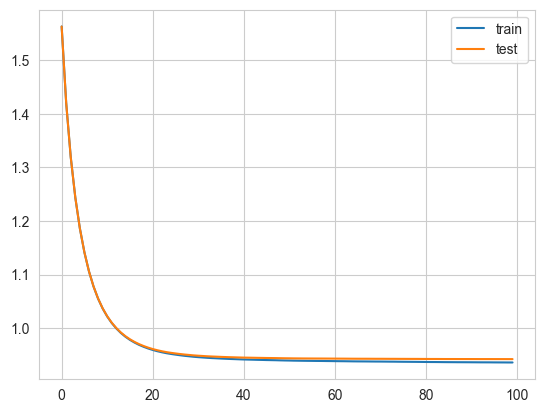

In [106]:
from xgboost import XGBClassifier

# Tuned on validation set
# Using class weights because of large class imbalance
# During training classifier samples training examples according to their class weights
class_weights = {
    'BLACK': 0.18,
    'WHITE': 0.22,
    'BLACK HISPANIC': 0.65,
    'WHITE HISPANIC': 0.22,
    'ASIAN / PACIFIC ISLANDER': 0.4,
    'AMERICAN INDIAN / ALASKAN NATIVE': 1
}

class_index_weights = {i: class_weights[label] for (i, label) in enumerate(labels_race)}
sample_weights = y_train_race.map(class_index_weights)

race_clf = XGBClassifier(learning_rate=0.2, n_estimators=100, tree_method='hist', max_depth=6, max_cat_to_onehot=6, enable_categorical=True)
race_clf.fit(X_train_race, y_train_race, eval_set=[(X_train_race, y_train_race), (X_val_race, y_val_race)], sample_weight=sample_weights)
results = race_clf.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.legend()
plt.show()

size of validation split: 233968
number of confident predictions: 233968
Accuracy: 0.6842773370717363
Precision: [0.81107114 0.60282509 0.617321   0.32337057 0.58594941 0.40895219], mean: 0.5582482298206518
Recall: [0.78728894 0.60469251 0.65231944 0.32458572 0.65108797 0.38358779], mean: 0.5672603947804613
F1 score: [0.79900311 0.60375736 0.63433784 0.323977   0.61680369 0.39586411], mean: 0.5622905177111744


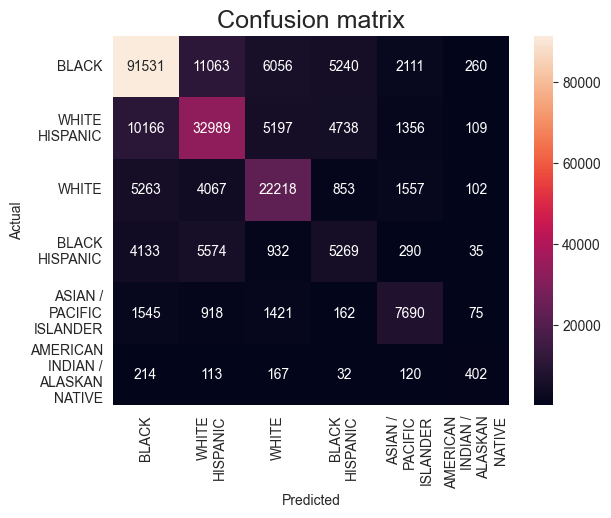

In [107]:
# Evaluating model on validation dataset and tuning hyperparameters
# confidence_threshold set to 0, so every prediction is included
eval_cat_model(race_clf, X_val_race, y_val_race, labels_race, confidence_threshold=0)

size of validation split: 233968
number of confident predictions: 135889
Accuracy: 0.8016616503175386
Precision: [0.87015376 0.76662013 0.74104773 0.41541234 0.70904783 0.5       ], mean: 0.6670469638079822
Recall: [0.92787611 0.39097333 0.76530156 0.52072814 0.7897713  0.5       ], mean: 0.6491084047645538
F1 score: [0.8980884  0.51784678 0.75297939 0.46214623 0.74723576 0.5       ], mean: 0.6463827584944739


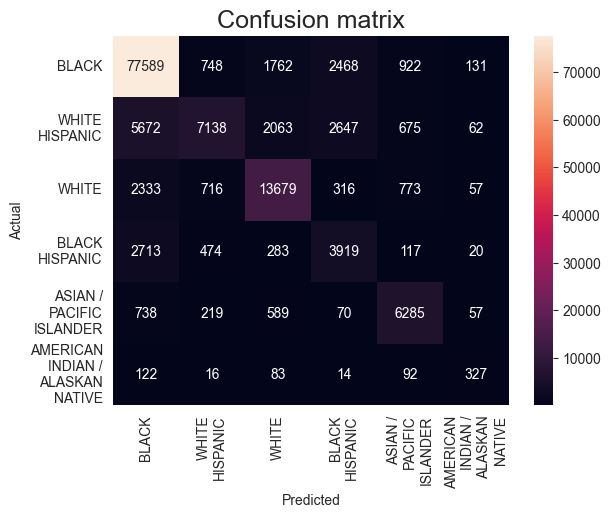

In [108]:
# Only predictions with at least 0.6 probability included
# Better results but only half of the examples are classified
eval_cat_model(race_clf, X_val_race, y_val_race, labels_race, confidence_threshold=0.6)

size of validation split: 233968
number of confident predictions: 233968
Accuracy: 0.6854698078369692
Precision: [0.81013195 0.60179701 0.62711723 0.32568193 0.5858672  0.42677824], mean: 0.5628955952584448
Recall: [0.78701136 0.605975   0.65612109 0.32933136 0.64854886 0.39688716], mean: 0.5706458040973698
F1 score: [0.79840431 0.60387878 0.64129139 0.32749648 0.61561659 0.41129032], mean: 0.5663296445162246


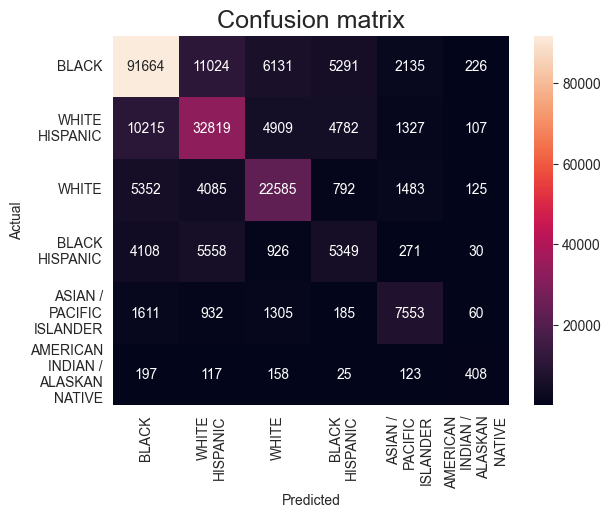

In [109]:
# Final evaluation of the model on test dataset. Dataset wasn't used for training nor hyperparameters fine-tuning
eval_cat_model(race_clf, X_test_race, y_test_race, labels_race, confidence_threshold=0)

In [142]:
# Predict missing suspect race in the dataset when necessary features for prediction are not NaN
# Save the results and prediction confidence to new columns

confidence_threshold = 0

missing_susp_race = data[data['SUSP_RACE'].isna()].dropna(subset=[*non_nullable])
susp_race_prediction, susp_race_prediction_confidence = predict(race_clf, missing_susp_race[features])
susp_race_prediction = labels_race[susp_race_prediction]
used_predictions = susp_race_prediction_confidence > confidence_threshold
missing_susp_race = missing_susp_race[used_predictions]
data.loc[missing_susp_race.index, 'SUSP_RACE_PREDICTED'] = susp_race_prediction[used_predictions]
data.loc[missing_susp_race.index, 'SUSP_RACE_PREDICTED_CONFIDENCE'] = susp_race_prediction_confidence[used_predictions]

In [143]:
data['SUSP_RACE_PREDICTED'].value_counts()

SUSP_RACE_PREDICTED
BLACK                               1249911
WHITE HISPANIC                       483576
WHITE                                470733
BLACK HISPANIC                       171828
ASIAN / PACIFIC ISLANDER             140974
AMERICAN INDIAN / ALASKAN NATIVE       9621
Name: count, dtype: int64